In [2]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm

In [7]:
# Read in AMF catalog
amf = pd.read_csv('dr9_main_complete.csv', header=None)
amf.columns = ['amf_no','amf_ra','amf_dec','amf_z','amf_lk','amf_rh','amf_r200','amf_rc','amf_c','amf_str_rh','bax_id','mcxc_id','red_id','whl_id']

c = SkyCoord(amf['amf_ra'],amf['amf_dec'],frame='icrs',unit='deg')
amf['glat'] = c.galactic.b.degree
amf['glon'] = c.galactic.l.degree

amf_whl = amf[(amf.whl_id!='-9999')]

In [6]:
hdul = fits.open("datafile2.fits")
data = hdul[1].data
dcl = pd.DataFrame({'RA':data['RA_PEAK'],
                    'dec':data['DEC_PEAK']})
c = SkyCoord(dcl['RA'],dcl['dec'],frame='icrs',unit='deg')
dcl['glat'] = c.galactic.b.degree
dcl['glon'] = c.galactic.l.degree
dcl.head()

RA        dec       glat        glon
0  146.489863  84.304263  30.975993  127.738006
1  156.959316  84.616116  31.440674  126.629288
2  158.208694  84.657256  31.478207  126.490970
3  159.227200  84.296723  31.827657  126.646232
4  160.328601  84.430737  31.779531  126.451662

In [10]:
amf_whl_dcl = pd.DataFrame()
amf_whl_dcl = pd.DataFrame(data=amf_whl_dcl, columns=amf_whl.columns)

In [11]:
amf_whl_dcl = amf_whl_dcl.iloc[0:0]

for i in tqdm(range(amf_whl.shape[0])):
    matches = dcl.loc[(dcl['glat'].sub(amf_whl.iloc[i]['glat']).abs()<1) & (dcl['glon'].sub(amf_whl.iloc[i]['glon']).abs()<1)]
    if len(matches)!=0:     
        amf_whl_dcl.loc[len(amf_whl_dcl)] = amf_whl.iloc[i]
        
amf_whl_dcl = amf_whl_dcl.reset_index()
print(len(amf_whl_dcl))
print(len(amf_whl_dcl[amf_whl_dcl.amf_rh>50]))

100%|██████████| 31950/31950 [07:03<00:00, 75.37it/s]

31535
2518


In [12]:
hdul = fits.open("../overlaps/masks/DR5_cluster-catalog_v1.1.fits")
data = hdul[1].data

adv = pd.DataFrame({'name':data['name'].byteswap().newbyteorder(),
                    'RA':data['RADeg'].byteswap().newbyteorder(),
                    'dec':data['decDeg'].byteswap().newbyteorder(),
                    'SNR':data['SNR'].byteswap().newbyteorder(),
                    'redshift':data['redshift'].byteswap().newbyteorder(),
                    'RM':data['RM'].byteswap().newbyteorder()})

c = SkyCoord(adv['RA'],adv['dec'],frame='icrs',unit='deg')
adv['glat'] = c.galactic.b.degree
adv['glon'] = c.galactic.l.degree

In [14]:
ard_not_adv = pd.DataFrame()
ard_not_adv = pd.DataFrame(data=ard_not_adv, columns=amf_whl_dcl.columns)

In [15]:
ard_not_adv = ard_not_adv.iloc[0:0]

for i in tqdm(range(amf_whl_dcl.shape[0])):
    matches = adv.loc[(adv['glat'].sub(amf_whl_dcl.iloc[i]['glat']).abs()<1) & (adv['glon'].sub(amf_whl_dcl.iloc[i]['glon']).abs()<1)]
    if len(matches)==0:     
        ard_not_adv.loc[len(ard_not_adv)] = amf_whl_dcl.iloc[i]
        
ard_not_adv = ard_not_adv.reset_index()
print(len(ard_not_adv))
print(len(ard_not_adv[ard_not_adv.amf_rh>50]))

100%|██████████| 31535/31535 [03:16<00:00, 160.61it/s]

21538
1546


In [18]:
ard_not_adv.head()

level_0  index  amf_no    amf_ra  amf_dec   amf_z    amf_lk    amf_rh  \
0        0    0.0     5.0  260.6324  32.1398  0.2252  222.1219  200.7117   
1        1    2.0     7.0  250.1485  46.6917  0.2248  225.9874  182.3373   
2        2    3.0     8.0  346.3402  21.0378  0.1453  121.0124  182.2769   
3        3    5.0    10.0  203.1873  50.5346  0.3110  164.8704  179.1883   
4        4    7.0    12.0  350.2432  29.2029  0.5231  165.0015  174.7108   

   amf_r200  amf_rc  amf_c  amf_str_rh      bax_id       mcxc_id  \
0     1.784   0.625  2.856     35.0001   ABELL2261  J1722.4+3208   
1     1.725   0.495  3.483     36.0001   ABELL2219  J1640.3+4642   
2     1.775   0.440  4.034     72.0001       -9999         -9999   
3     1.663   0.422  3.939     31.0001  ABELL1758A  J1332.7+5032   
4     1.518   0.390  3.892     69.0001       -9999         -9999   

                 red_id            whl_id       glat        glon  
0  RMJ172227.2+320757.2  J172227.2+320757  31.846666   55.602221  
1  RMJ164019.8+464241.5  J164019.8+464242  41.429880   72.599428  
2  RMJ230520.1+210313.5  J230520.1+210313 -35.420653   92.175825  
3  RMJ133238.4+503336.0  J133252.1+503134  65.305106  107.103759  
4  RMJ232104.1+291134.5  J232104.1+291134 -29.646780  100.211077

In [16]:
ard_not_adv.to_csv("ard_not_adv.csv")

---

In [17]:
actmap = enmap.read_map("act_dr5.01_s08s18_AA_f090_daynight_map.fits")

In [3]:
actmap_hp = reproject.healpix_from_enmap(actmap[0],nside=2048,lmax=4000)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/maamari/Documents/Other/Anaconda/lib/python

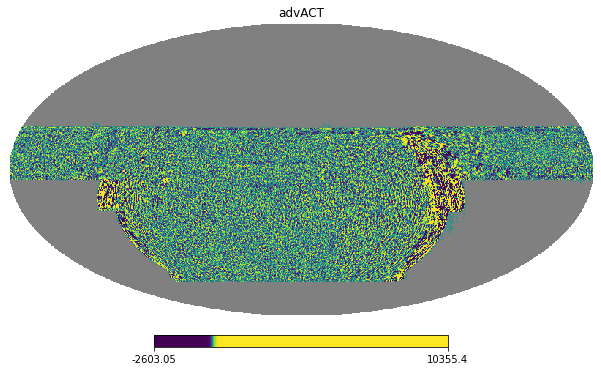

In [4]:
NSIDE = 2048
act_w_cmb = hp.ma(actmap_hp)
mask = np.zeros(hp.nside2npix(NSIDE), dtype=np.bool)
mask[(actmap_hp < 5) & (actmap_hp > -5)] = 1
act_w_cmb.mask = mask
hp.mollview(act_w_cmb,norm='hist',title='advACT')

In [7]:
cmb = hp.read_map("COM_CMB_IQU-nilc_2048_R3.00_full.fits")

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


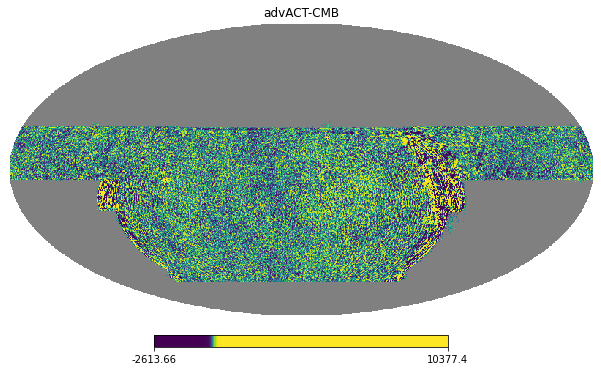

In [8]:
NSIDE = 2048
act_no_cmb = hp.ma(actmap_hp-(cmb*(1000000/3)))
mask = np.zeros(hp.nside2npix(NSIDE), dtype=np.bool)
mask[(actmap_hp < 5) & (actmap_hp > -5)] = 1
act_no_cmb.mask = mask
hp.mollview(act_no_cmb,norm='hist',title='advACT-CMB')

  0%|          | 0/1546 [00:00<?, ?it/s]

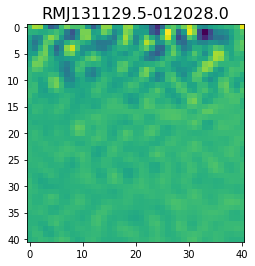

  0%|          | 3/1546 [00:00<02:06, 12.16it/s]

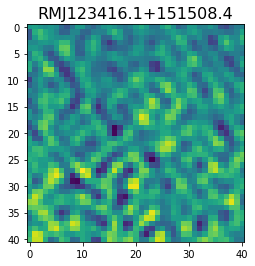

  1%|          | 13/1546 [00:00<00:58, 26.36it/s]

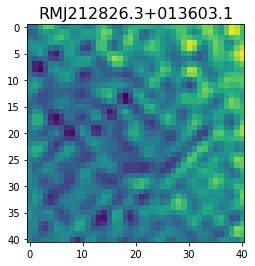

  1%|          | 17/1546 [00:00<01:22, 18.61it/s]

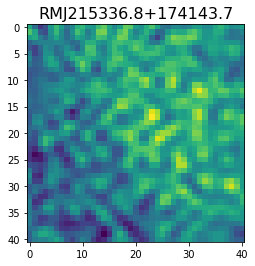

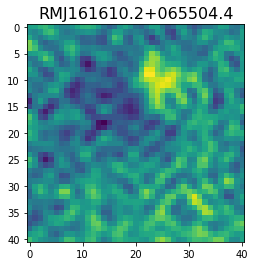

  1%|▏         | 20/1546 [00:01<01:45, 14.42it/s]

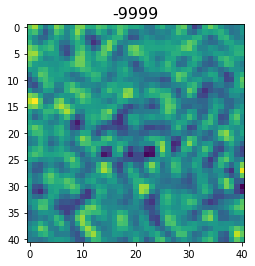

  2%|▏         | 24/1546 [00:01<01:35, 15.93it/s]

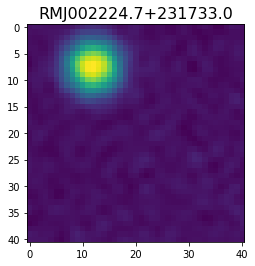

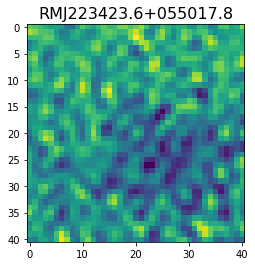

  2%|▏         | 26/1546 [00:01<01:58, 12.79it/s]

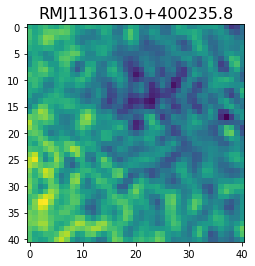

  2%|▏         | 28/1546 [00:01<02:08, 11.81it/s]

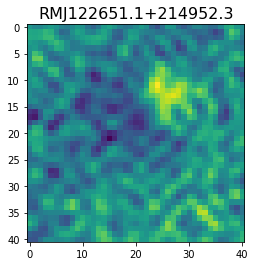

  2%|▏         | 30/1546 [00:02<02:10, 11.64it/s]

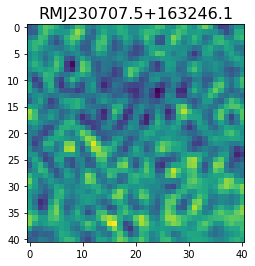

  2%|▏         | 35/1546 [00:02<01:39, 15.18it/s]

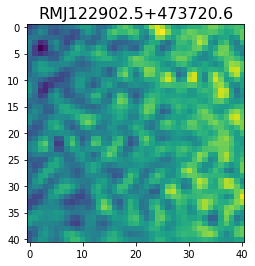

  3%|▎         | 39/1546 [00:02<01:31, 16.53it/s]

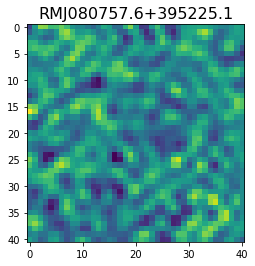

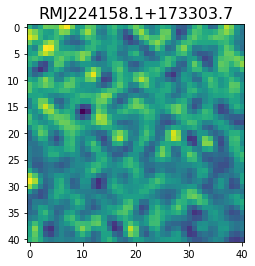

  3%|▎         | 46/1546 [00:02<01:20, 18.56it/s]

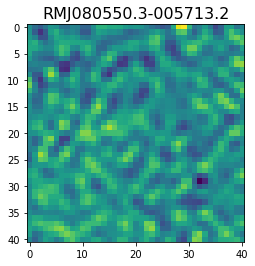

  3%|▎         | 49/1546 [00:03<01:19, 18.78it/s]

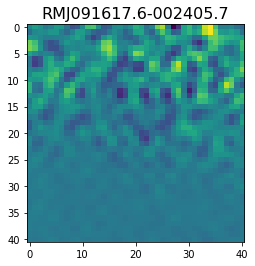

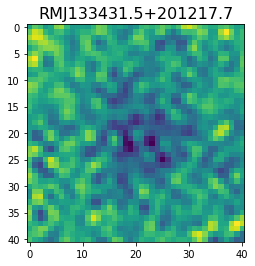

  3%|▎         | 52/1546 [00:03<01:40, 14.87it/s]

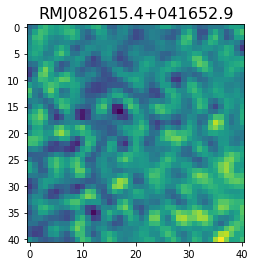

  5%|▍         | 70/1546 [00:03<00:45, 32.57it/s]

  5%|▍         | 74/1546 [00:04<00:54, 27.06it/s]

  5%|▌         | 78/1546 [00:04<00:58, 25.10it/s]

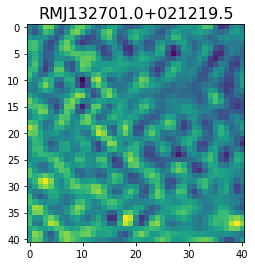

  5%|▌         | 81/1546 [00:04<01:06, 22.00it/s]

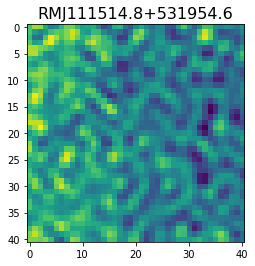

  5%|▌         | 84/1546 [00:04<01:27, 16.77it/s]

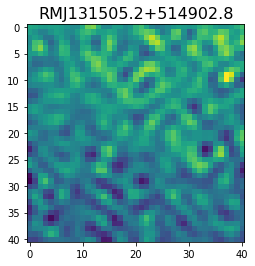

  6%|▌         | 87/1546 [00:04<01:27, 16.73it/s]

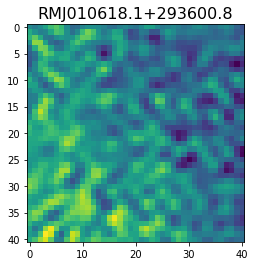

  6%|▌         | 89/1546 [00:05<01:36, 15.12it/s]

  6%|▌         | 94/1546 [00:05<01:23, 17.32it/s]

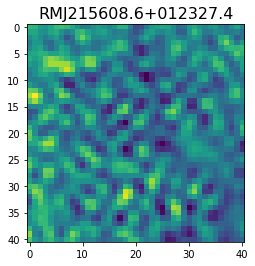

  6%|▋         | 97/1546 [00:05<01:25, 16.95it/s]

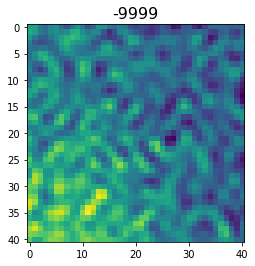

  6%|▋         | 99/1546 [00:05<01:33, 15.46it/s]

  7%|▋         | 102/1546 [00:05<01:29, 16.11it/s]

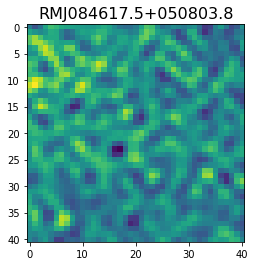

  7%|▋         | 104/1546 [00:06<01:36, 14.95it/s]

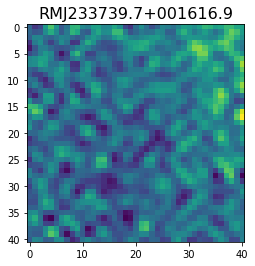

  7%|▋         | 108/1546 [00:06<01:25, 16.89it/s]

  7%|▋         | 112/1546 [00:06<01:20, 17.81it/s]

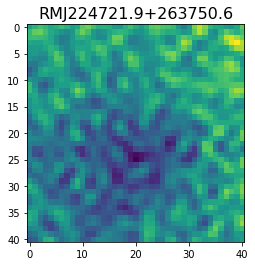

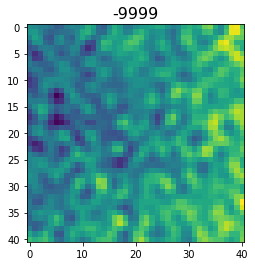

  7%|▋         | 114/1546 [00:06<01:44, 13.69it/s]

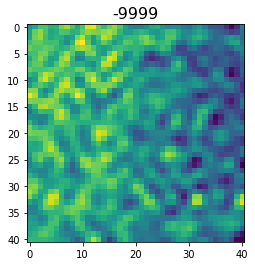

  8%|▊         | 117/1546 [00:06<01:41, 14.12it/s]

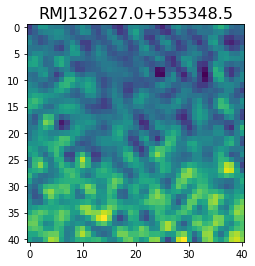

  8%|▊         | 119/1546 [00:07<01:55, 12.35it/s]

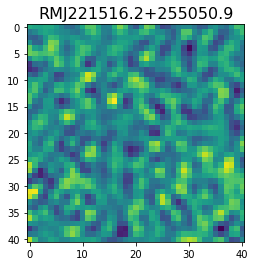

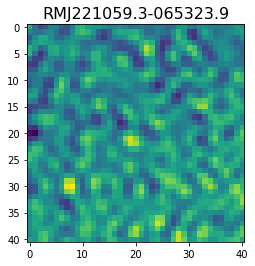

  8%|▊         | 127/1546 [00:07<01:20, 17.68it/s]

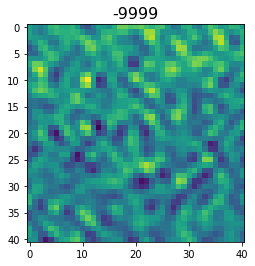

  9%|▉         | 136/1546 [00:07<00:58, 24.13it/s]

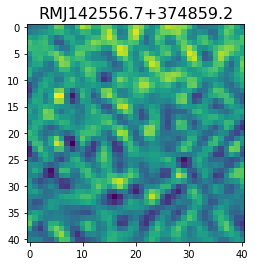

  9%|▉         | 140/1546 [00:08<01:01, 22.93it/s]

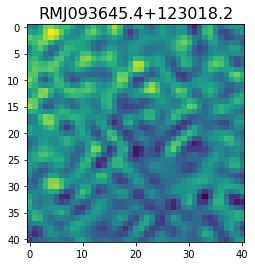

  9%|▉         | 143/1546 [00:08<01:06, 21.25it/s]

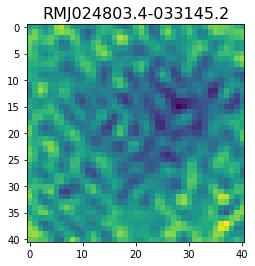

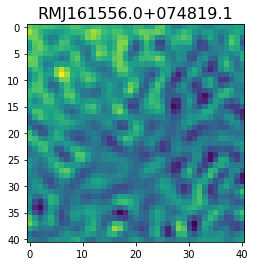

 10%|▉         | 152/1546 [00:08<01:04, 21.50it/s]

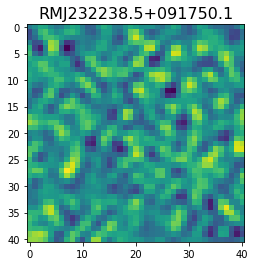

 10%|█         | 156/1546 [00:08<01:05, 21.13it/s]

 10%|█         | 160/1546 [00:09<01:12, 19.24it/s]

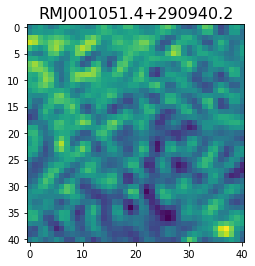

 11%|█         | 163/1546 [00:09<01:15, 18.41it/s]

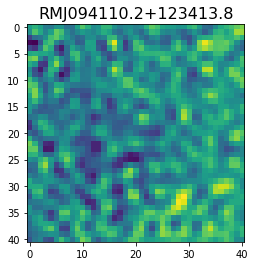

 11%|█         | 166/1546 [00:09<01:19, 17.36it/s]

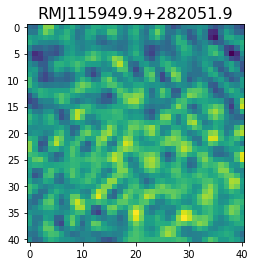

 11%|█         | 168/1546 [00:09<01:24, 16.37it/s]

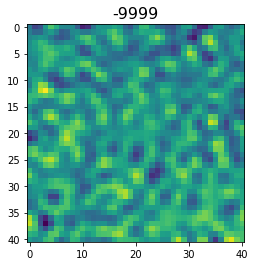

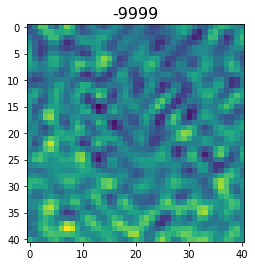

 11%|█         | 170/1546 [00:10<01:56, 11.81it/s]

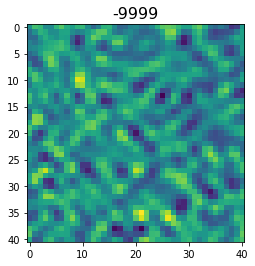

 11%|█         | 173/1546 [00:10<01:44, 13.20it/s]

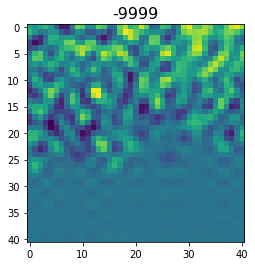

 12%|█▏        | 188/1546 [00:10<00:48, 27.86it/s]

 12%|█▏        | 192/1546 [00:10<00:55, 24.38it/s]

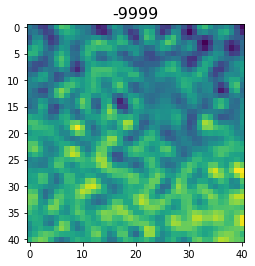

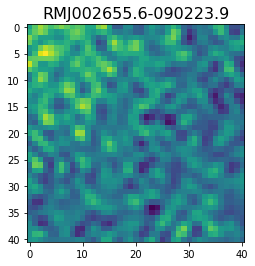

 13%|█▎        | 195/1546 [00:11<01:19, 16.89it/s]

 13%|█▎        | 198/1546 [00:11<01:21, 16.61it/s]

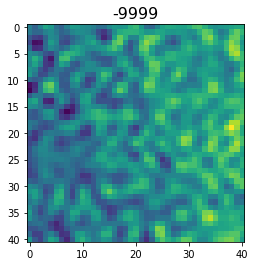

 13%|█▎        | 201/1546 [00:11<01:19, 17.00it/s]

 13%|█▎        | 204/1546 [00:11<01:17, 17.38it/s]

 13%|█▎        | 206/1546 [00:11<01:23, 16.01it/s]

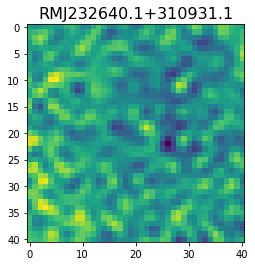

 13%|█▎        | 208/1546 [00:12<01:26, 15.55it/s]

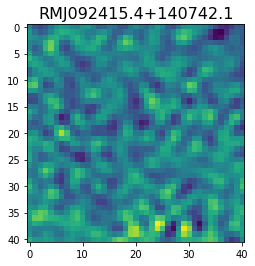

 14%|█▎        | 211/1546 [00:12<01:21, 16.43it/s]

 14%|█▍        | 213/1546 [00:12<01:41, 13.15it/s]

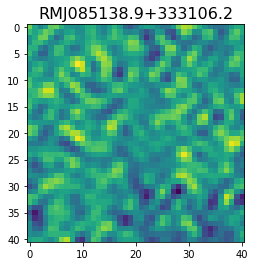

 14%|█▍        | 215/1546 [00:12<01:39, 13.32it/s]

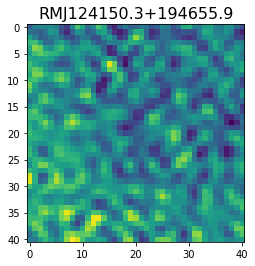

 14%|█▍        | 217/1546 [00:12<01:39, 13.40it/s]

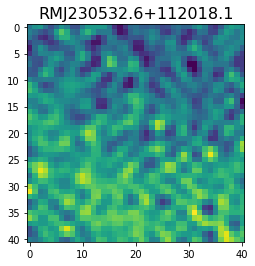

 14%|█▍        | 222/1546 [00:12<01:16, 17.38it/s]

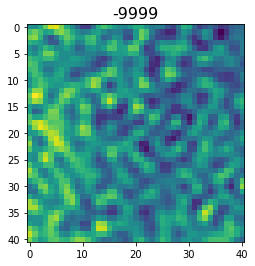

 15%|█▍        | 226/1546 [00:13<01:14, 17.74it/s]

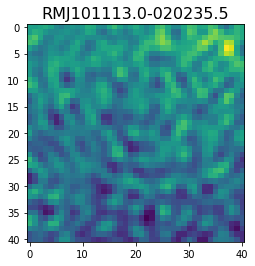

 15%|█▌        | 234/1546 [00:13<00:53, 24.53it/s]

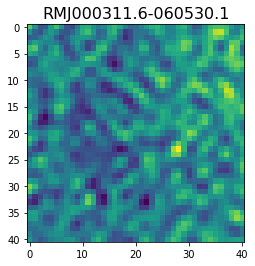

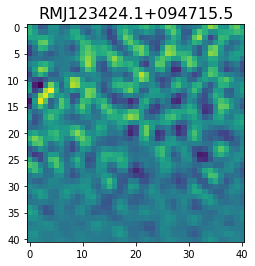

 15%|█▌        | 237/1546 [00:13<01:10, 18.67it/s]

 16%|█▌        | 240/1546 [00:13<01:15, 17.27it/s]

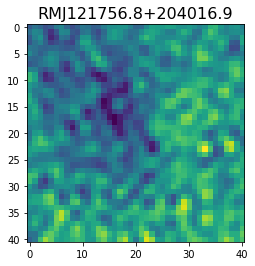

 16%|█▌        | 243/1546 [00:14<01:16, 16.95it/s]

 16%|█▌        | 246/1546 [00:14<01:17, 16.83it/s]

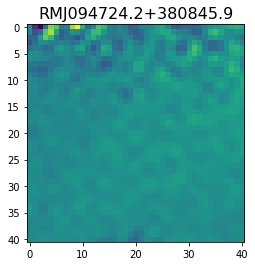

 16%|█▌        | 250/1546 [00:14<01:12, 17.79it/s]

 16%|█▋        | 254/1546 [00:14<01:09, 18.72it/s]

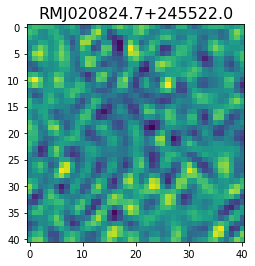

 17%|█▋        | 264/1546 [00:15<00:52, 24.22it/s]

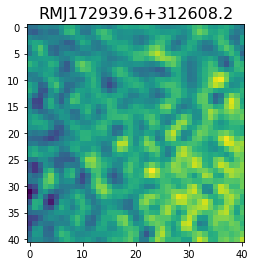

 17%|█▋        | 268/1546 [00:15<00:55, 23.02it/s]

 18%|█▊        | 271/1546 [00:15<00:59, 21.29it/s]

 18%|█▊        | 274/1546 [00:15<01:03, 20.02it/s]

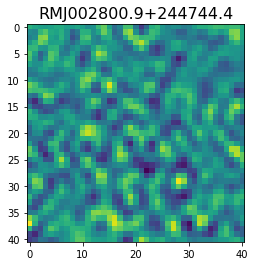

 18%|█▊        | 277/1546 [00:15<01:06, 19.13it/s]

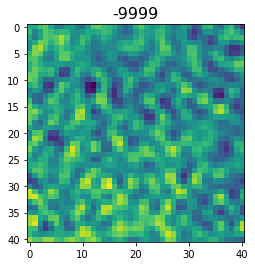

 18%|█▊        | 280/1546 [00:15<01:09, 18.32it/s]

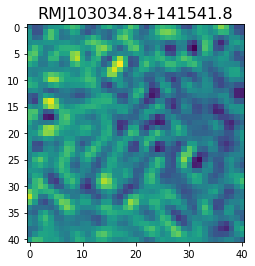

 18%|█▊        | 282/1546 [00:16<01:15, 16.78it/s]

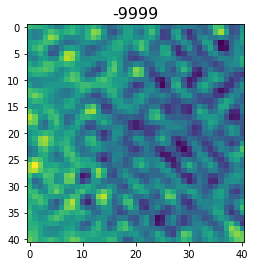

 18%|█▊        | 284/1546 [00:16<01:20, 15.74it/s]

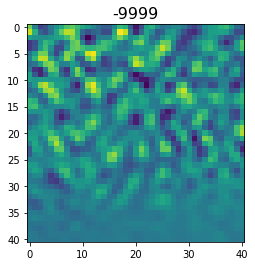

 18%|█▊        | 286/1546 [00:16<01:25, 14.80it/s]

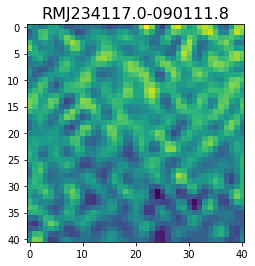

 19%|█▊        | 288/1546 [00:16<01:28, 14.23it/s]

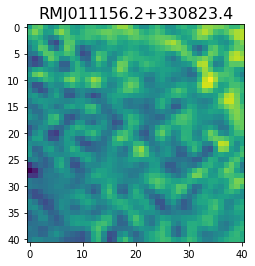

 19%|█▉        | 290/1546 [00:16<01:31, 13.74it/s]

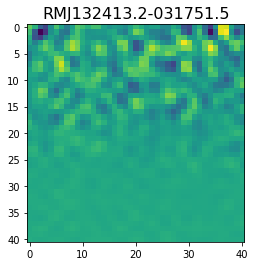

 19%|█▉        | 296/1546 [00:16<01:07, 18.44it/s]

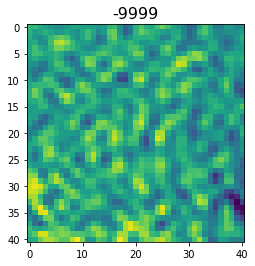

 19%|█▉        | 298/1546 [00:17<01:13, 16.95it/s]

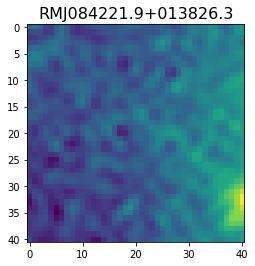

 20%|█▉        | 303/1546 [00:17<01:12, 17.18it/s]

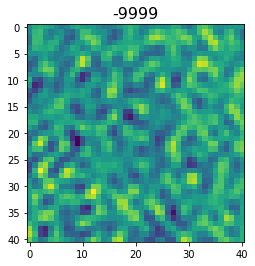

 20%|█▉        | 305/1546 [00:17<01:17, 16.03it/s]

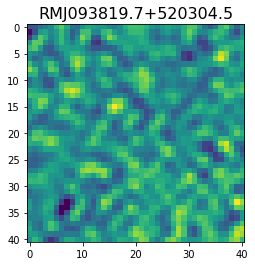

 20%|█▉        | 307/1546 [00:17<01:21, 15.25it/s]

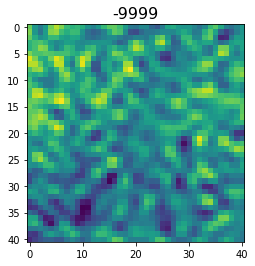

 20%|██        | 310/1546 [00:17<01:18, 15.75it/s]

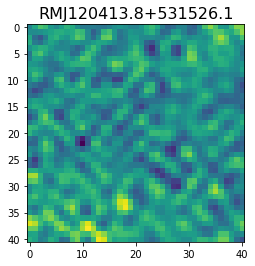

 20%|██        | 312/1546 [00:18<01:22, 14.98it/s]

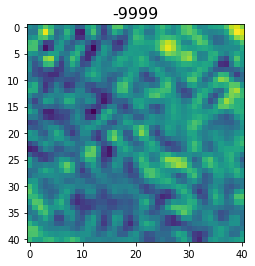

 20%|██        | 314/1546 [00:18<01:23, 14.73it/s]

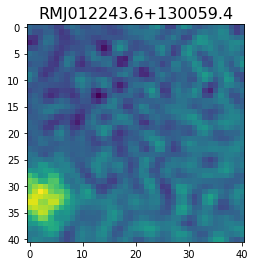

 21%|██        | 318/1546 [00:18<01:12, 16.96it/s]

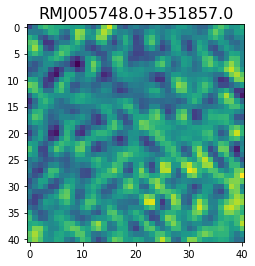

 21%|██        | 322/1546 [00:18<01:06, 18.37it/s]

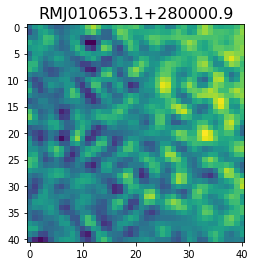

 21%|██        | 324/1546 [00:18<01:30, 13.50it/s]

 21%|██        | 327/1546 [00:19<01:24, 14.35it/s]

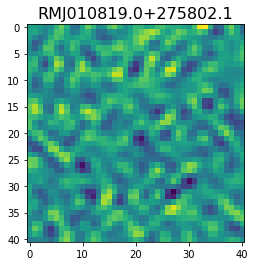

 21%|██▏       | 331/1546 [00:19<01:15, 16.15it/s]

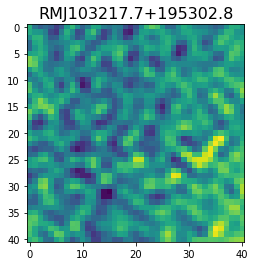

 22%|██▏       | 333/1546 [00:19<01:18, 15.43it/s]

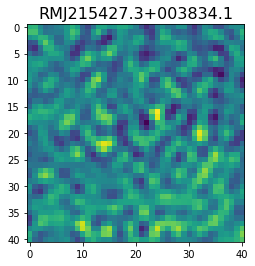

 22%|██▏       | 338/1546 [00:19<01:13, 16.54it/s]

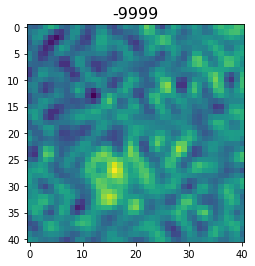

 22%|██▏       | 340/1546 [00:19<01:16, 15.83it/s]

 22%|██▏       | 342/1546 [00:19<01:20, 15.01it/s]

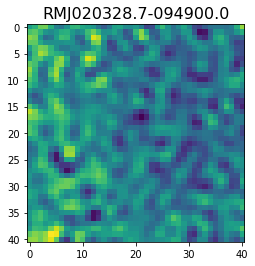

 22%|██▏       | 345/1546 [00:20<01:16, 15.71it/s]

 23%|██▎       | 351/1546 [00:20<01:01, 19.54it/s]

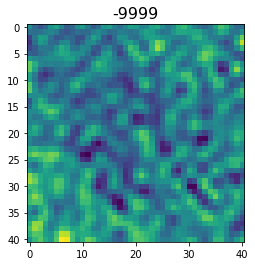

 23%|██▎       | 353/1546 [00:20<01:06, 18.00it/s]

 23%|██▎       | 356/1546 [00:20<01:06, 17.94it/s]

 23%|██▎       | 359/1546 [00:20<01:07, 17.69it/s]

 23%|██▎       | 361/1546 [00:21<01:13, 16.18it/s]

 24%|██▎       | 364/1546 [00:21<01:11, 16.57it/s]

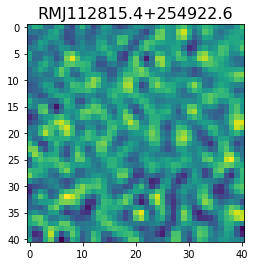

 24%|██▎       | 366/1546 [00:21<01:17, 15.13it/s]

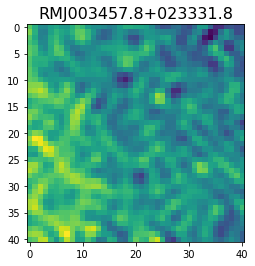

 24%|██▍       | 368/1546 [00:21<01:20, 14.58it/s]

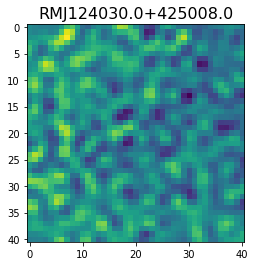

 24%|██▍       | 373/1546 [00:21<01:05, 17.79it/s]

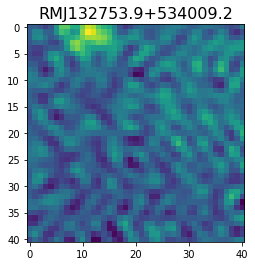

 25%|██▍       | 381/1546 [00:22<00:53, 21.82it/s]

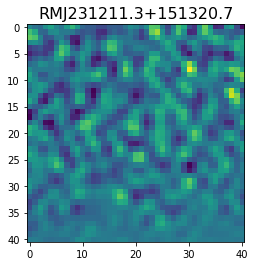

 25%|██▌       | 387/1546 [00:22<00:50, 23.17it/s]

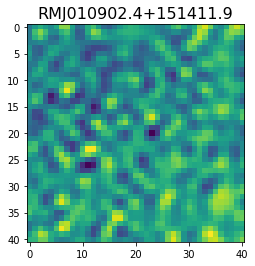

 26%|██▌       | 396/1546 [00:22<00:47, 24.40it/s]

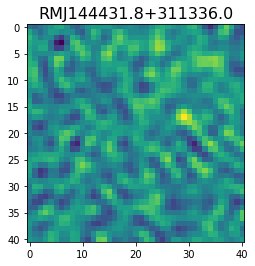

 26%|██▋       | 406/1546 [00:23<00:38, 29.83it/s]

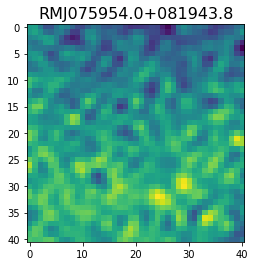

 27%|██▋       | 410/1546 [00:23<00:59, 19.04it/s]

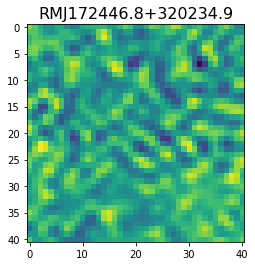

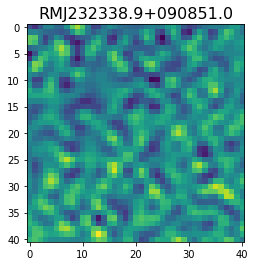

 27%|██▋       | 413/1546 [00:23<01:10, 16.15it/s]

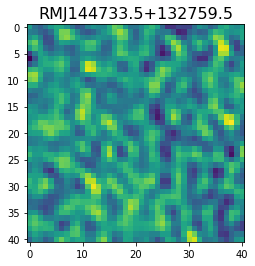

 27%|██▋       | 416/1546 [00:23<01:08, 16.48it/s]

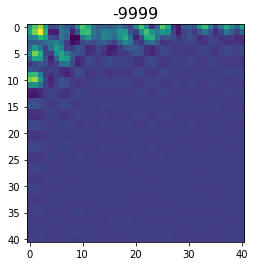

 27%|██▋       | 420/1546 [00:24<01:03, 17.81it/s]

 27%|██▋       | 423/1546 [00:24<01:02, 17.97it/s]

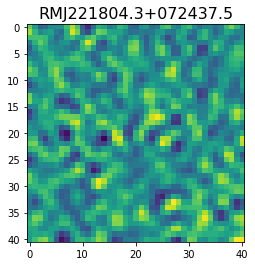

 28%|██▊       | 426/1546 [00:24<01:08, 16.24it/s]

 28%|██▊       | 434/1546 [00:24<00:47, 23.34it/s]

 28%|██▊       | 437/1546 [00:24<00:50, 21.81it/s]

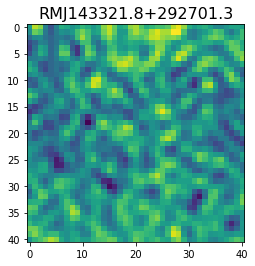

 28%|██▊       | 440/1546 [00:25<00:54, 20.40it/s]

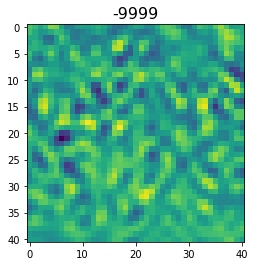

 29%|██▊       | 443/1546 [00:25<00:56, 19.60it/s]

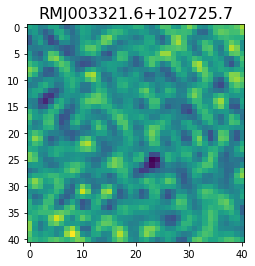

 29%|██▉       | 446/1546 [00:25<01:09, 15.86it/s]

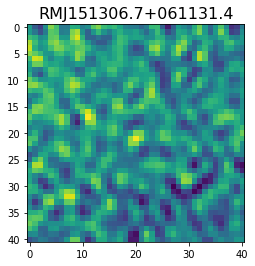

 29%|██▉       | 448/1546 [00:25<01:12, 15.13it/s]

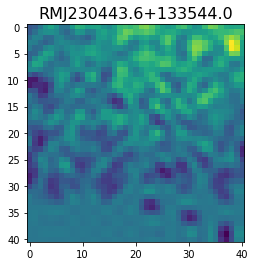

 29%|██▉       | 450/1546 [00:25<01:15, 14.57it/s]

 29%|██▉       | 452/1546 [00:26<01:20, 13.66it/s]

 29%|██▉       | 455/1546 [00:26<01:18, 13.83it/s]

 30%|███       | 465/1546 [00:26<00:48, 22.17it/s]

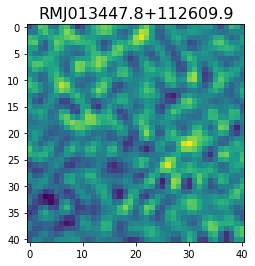

 30%|███       | 468/1546 [00:26<00:53, 20.16it/s]

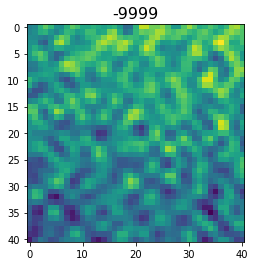

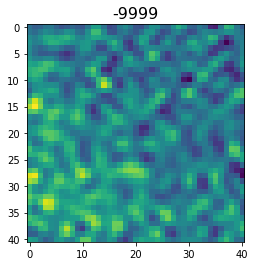

 30%|███       | 471/1546 [00:27<01:11, 15.11it/s]

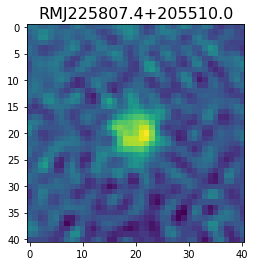

 31%|███       | 475/1546 [00:27<01:03, 16.89it/s]

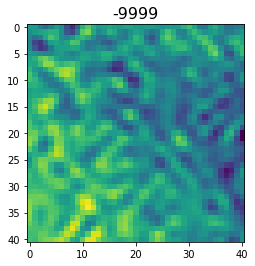

 31%|███       | 478/1546 [00:27<01:02, 17.22it/s]

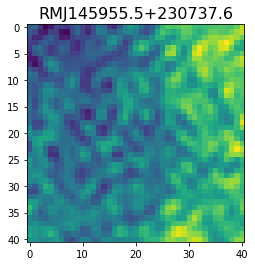

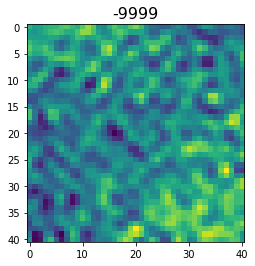

 31%|███       | 480/1546 [00:27<01:17, 13.76it/s]

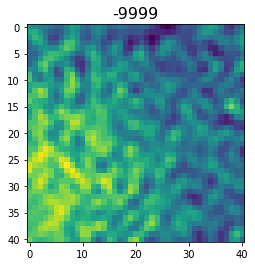

 31%|███       | 482/1546 [00:27<01:17, 13.75it/s]

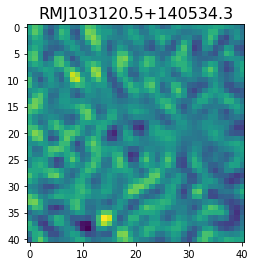

 31%|███▏      | 484/1546 [00:27<01:17, 13.62it/s]

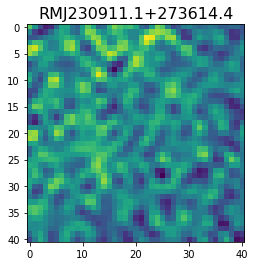

 31%|███▏      | 486/1546 [00:28<01:18, 13.45it/s]

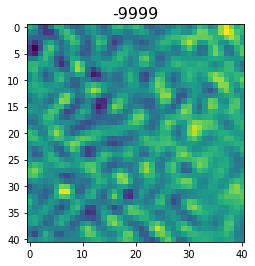

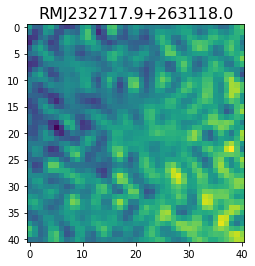

 32%|███▏      | 488/1546 [00:28<01:34, 11.21it/s]

 32%|███▏      | 491/1546 [00:28<01:23, 12.68it/s]

 33%|███▎      | 505/1546 [00:28<00:35, 29.42it/s]

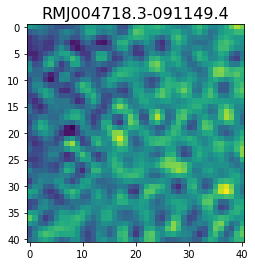

 33%|███▎      | 509/1546 [00:29<00:44, 23.49it/s]

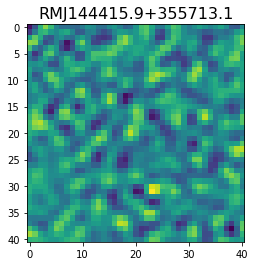

 33%|███▎      | 512/1546 [00:29<00:47, 21.57it/s]

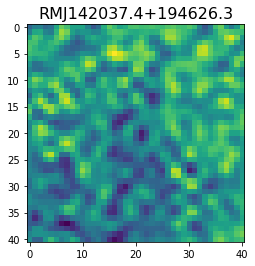

 33%|███▎      | 515/1546 [00:29<00:51, 20.21it/s]

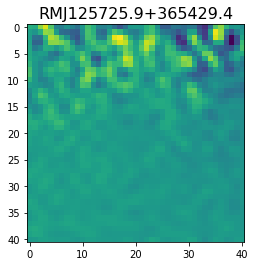

 34%|███▎      | 518/1546 [00:29<00:53, 19.11it/s]

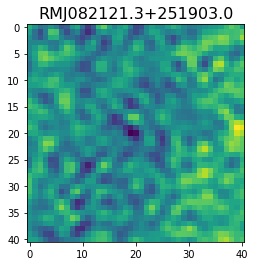

 34%|███▎      | 521/1546 [00:29<00:56, 18.28it/s]

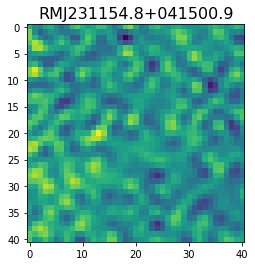

 34%|███▍      | 525/1546 [00:30<00:53, 18.93it/s]

 34%|███▍      | 531/1546 [00:30<00:47, 21.32it/s]

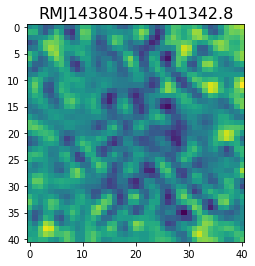

 35%|███▍      | 534/1546 [00:30<00:50, 20.23it/s]

 35%|███▍      | 540/1546 [00:30<00:45, 22.34it/s]

 35%|███▌      | 543/1546 [00:30<00:49, 20.47it/s]

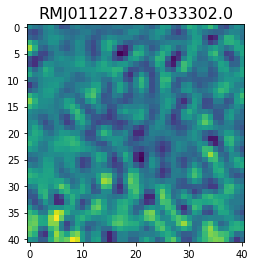

 35%|███▌      | 546/1546 [00:31<00:54, 18.50it/s]

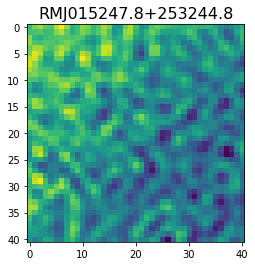

 36%|███▌      | 555/1546 [00:31<00:40, 24.73it/s]

 37%|███▋      | 566/1546 [00:31<00:32, 30.31it/s]

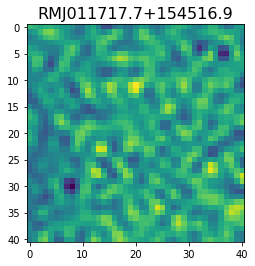

 37%|███▋      | 570/1546 [00:32<00:48, 20.31it/s]

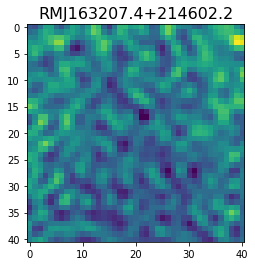

 37%|███▋      | 575/1546 [00:32<00:45, 21.23it/s]

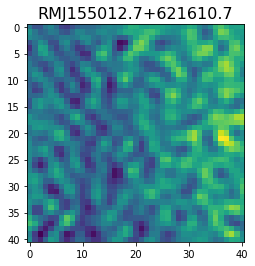

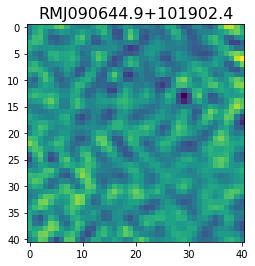

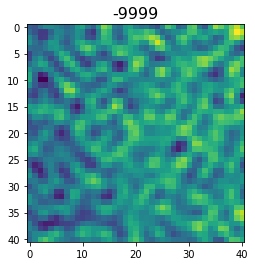

 37%|███▋      | 578/1546 [00:32<01:05, 14.83it/s]

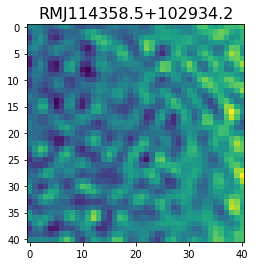

 38%|███▊      | 581/1546 [00:32<01:03, 15.14it/s]

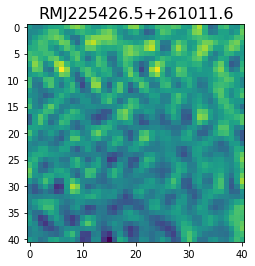

 38%|███▊      | 584/1546 [00:33<01:01, 15.67it/s]

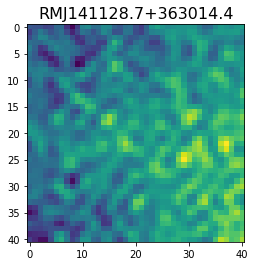

 38%|███▊      | 586/1546 [00:33<01:03, 15.06it/s]

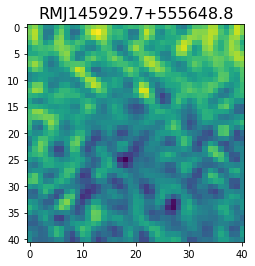

 38%|███▊      | 588/1546 [00:33<01:05, 14.52it/s]

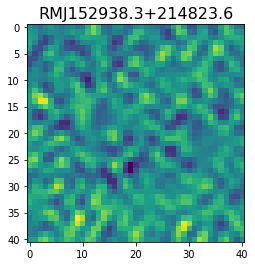

 38%|███▊      | 591/1546 [00:33<01:03, 14.99it/s]

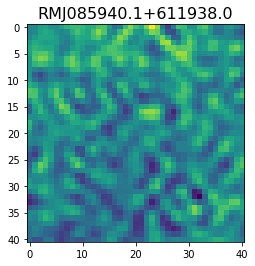

 38%|███▊      | 593/1546 [00:33<01:06, 14.41it/s]

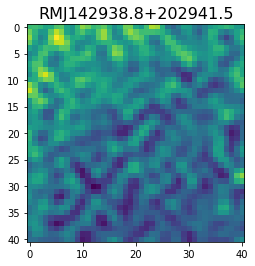

 38%|███▊      | 595/1546 [00:33<01:08, 13.85it/s]

 39%|███▊      | 597/1546 [00:34<01:19, 12.01it/s]

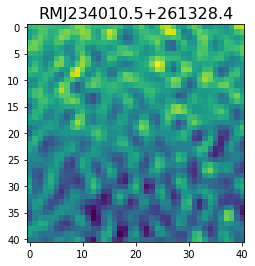

 39%|███▊      | 599/1546 [00:34<01:33, 10.10it/s]

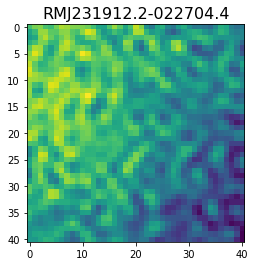

 39%|███▉      | 601/1546 [00:34<01:28, 10.67it/s]

 39%|███▉      | 603/1546 [00:34<01:24, 11.18it/s]

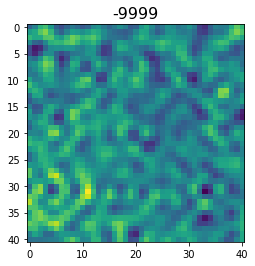

 39%|███▉      | 605/1546 [00:35<01:37,  9.66it/s]

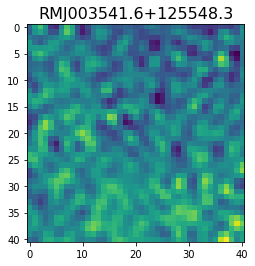

 39%|███▉      | 610/1546 [00:35<01:08, 13.64it/s]

 40%|███▉      | 612/1546 [00:35<01:09, 13.38it/s]

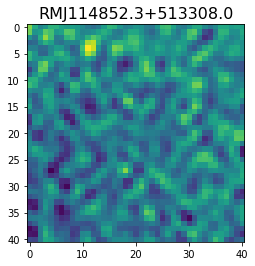

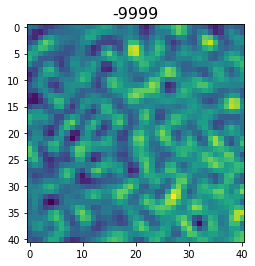

 40%|████      | 620/1546 [00:35<00:50, 18.27it/s]

 40%|████      | 625/1546 [00:36<00:46, 19.65it/s]

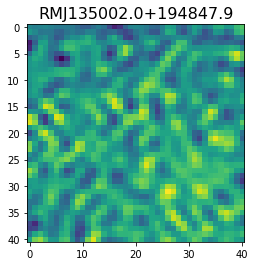

 41%|████      | 628/1546 [00:36<00:48, 19.01it/s]

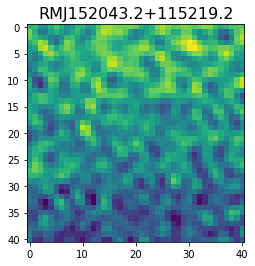

 41%|████      | 634/1546 [00:36<00:46, 19.46it/s]

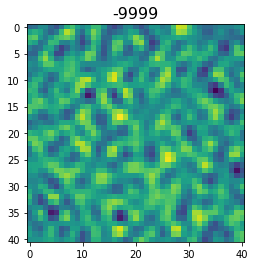

 41%|████      | 637/1546 [00:36<00:47, 19.02it/s]

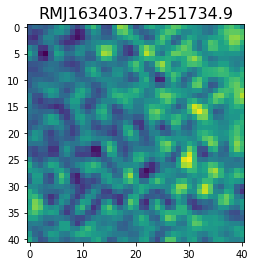

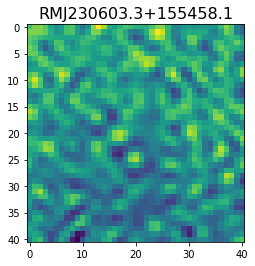

 41%|████▏     | 640/1546 [00:36<00:57, 15.67it/s]

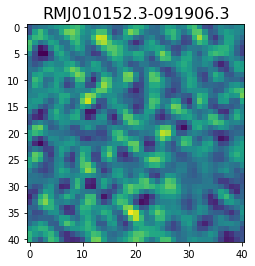

 42%|████▏     | 642/1546 [00:37<01:10, 12.81it/s]

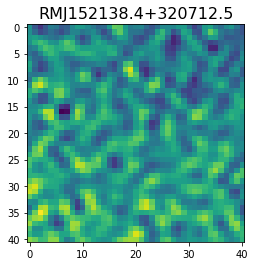

 42%|████▏     | 645/1546 [00:37<01:05, 13.80it/s]

 42%|████▏     | 647/1546 [00:37<01:17, 11.63it/s]

 42%|████▏     | 649/1546 [00:37<01:14, 11.99it/s]

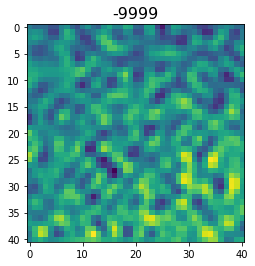

 42%|████▏     | 651/1546 [00:38<01:25, 10.44it/s]

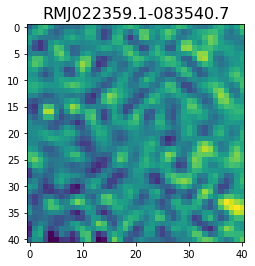

 42%|████▏     | 653/1546 [00:38<01:21, 10.91it/s]

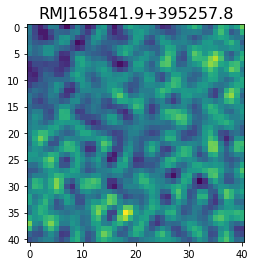

 42%|████▏     | 655/1546 [00:38<01:26, 10.31it/s]

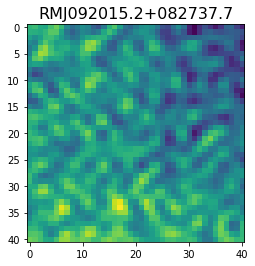

 43%|████▎     | 658/1546 [00:38<01:13, 12.07it/s]

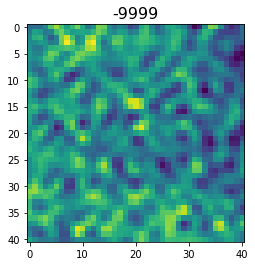

 43%|████▎     | 660/1546 [00:38<01:12, 12.25it/s]

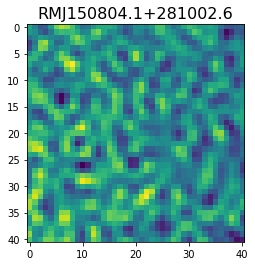

 43%|████▎     | 662/1546 [00:39<01:11, 12.42it/s]

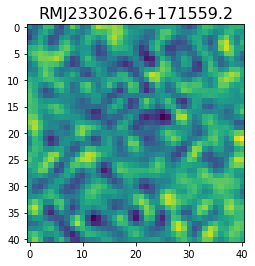

 43%|████▎     | 666/1546 [00:39<00:58, 15.11it/s]

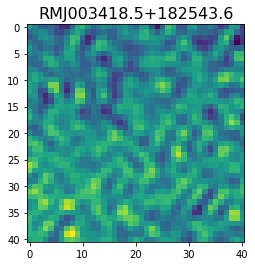

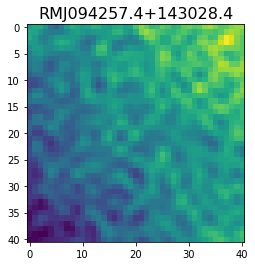

 43%|████▎     | 668/1546 [00:39<01:13, 12.01it/s]

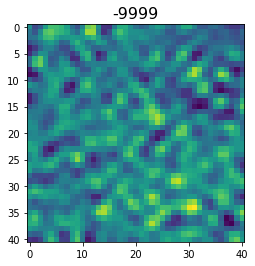

 43%|████▎     | 671/1546 [00:39<01:05, 13.28it/s]

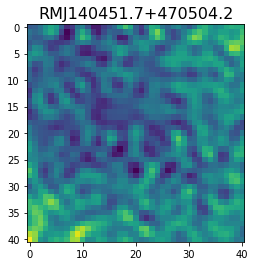

 44%|████▎     | 673/1546 [00:39<01:05, 13.25it/s]

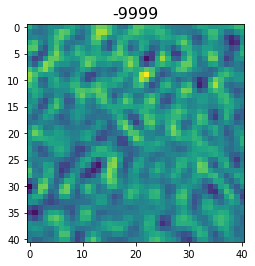

 44%|████▎     | 675/1546 [00:39<01:05, 13.29it/s]

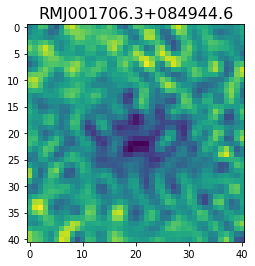

 44%|████▍     | 677/1546 [00:40<01:18, 11.03it/s]

 44%|████▍     | 685/1546 [00:40<00:42, 20.32it/s]

 45%|████▍     | 691/1546 [00:40<00:41, 20.52it/s]

 45%|████▍     | 694/1546 [00:40<00:44, 19.32it/s]

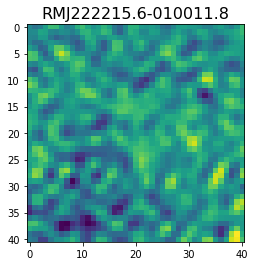

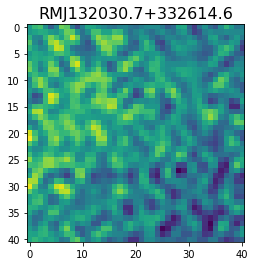

 45%|████▌     | 703/1546 [00:41<00:39, 21.50it/s]

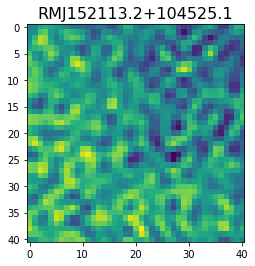

 46%|████▌     | 706/1546 [00:41<00:41, 20.20it/s]

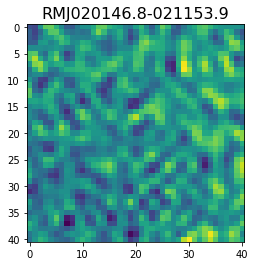

 46%|████▌     | 709/1546 [00:41<00:43, 19.46it/s]

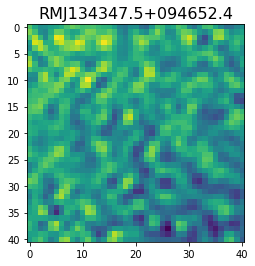

 46%|████▌     | 712/1546 [00:41<00:44, 18.94it/s]

 46%|████▌     | 715/1546 [00:42<00:44, 18.57it/s]

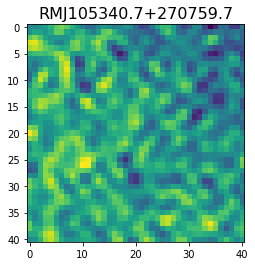

 46%|████▋     | 718/1546 [00:42<00:45, 18.19it/s]

 47%|████▋     | 721/1546 [00:42<00:45, 17.97it/s]

 47%|████▋     | 724/1546 [00:42<00:46, 17.50it/s]

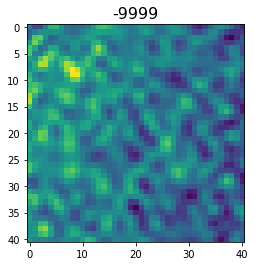

 47%|████▋     | 726/1546 [00:42<00:51, 15.92it/s]

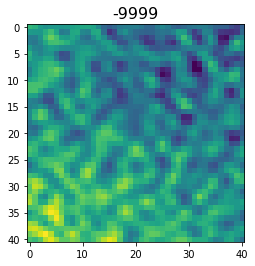

 47%|████▋     | 732/1546 [00:43<00:41, 19.46it/s]

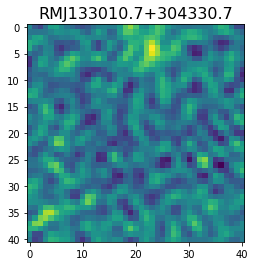

 48%|████▊     | 741/1546 [00:43<00:33, 23.70it/s]

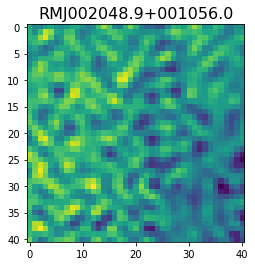

 48%|████▊     | 745/1546 [00:43<00:36, 22.16it/s]

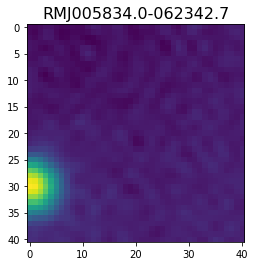

 48%|████▊     | 748/1546 [00:43<00:39, 20.24it/s]

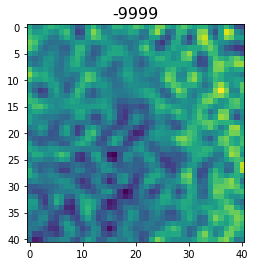

 49%|████▊     | 751/1546 [00:43<00:41, 19.20it/s]

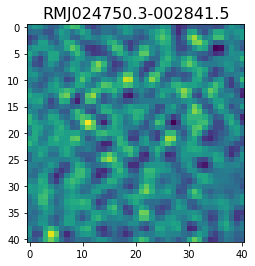

 49%|████▉     | 763/1546 [00:44<00:28, 27.69it/s]

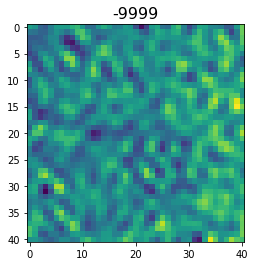

 50%|████▉     | 767/1546 [00:44<00:36, 21.49it/s]

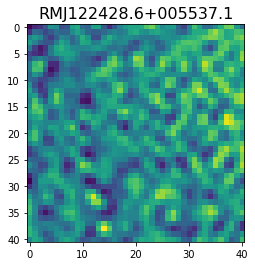

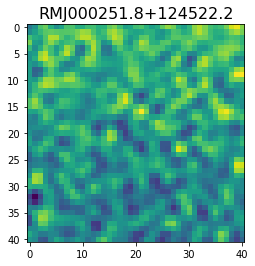

 50%|████▉     | 770/1546 [00:44<00:45, 17.15it/s]

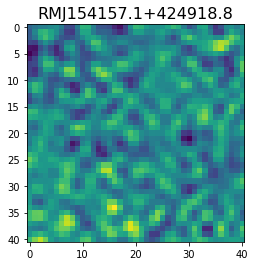

 50%|█████     | 774/1546 [00:45<00:42, 18.15it/s]

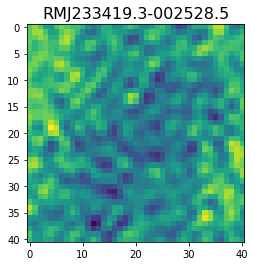

 50%|█████     | 779/1546 [00:45<00:38, 19.87it/s]

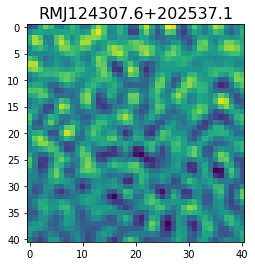

 51%|█████     | 782/1546 [00:45<00:40, 19.05it/s]

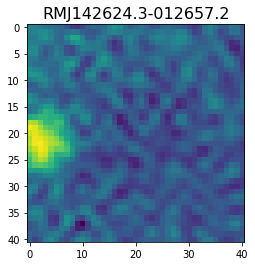

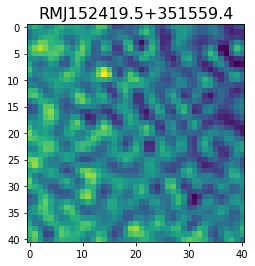

 51%|█████     | 785/1546 [00:45<00:52, 14.52it/s]

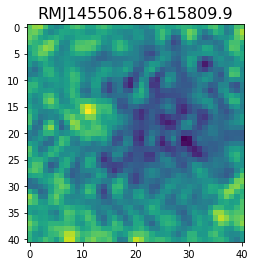

 51%|█████     | 787/1546 [00:45<00:53, 14.18it/s]

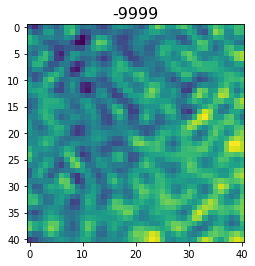

 51%|█████     | 790/1546 [00:46<00:51, 14.66it/s]

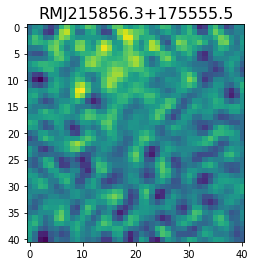

 51%|█████▏    | 793/1546 [00:46<00:49, 15.25it/s]

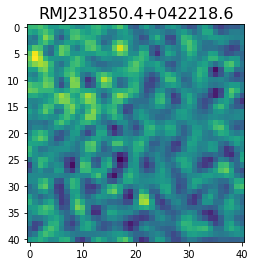

 52%|█████▏    | 799/1546 [00:46<00:39, 18.92it/s]

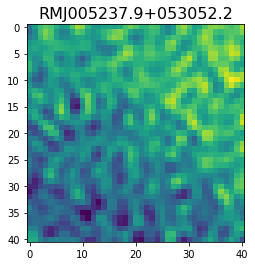

 52%|█████▏    | 801/1546 [00:46<00:42, 17.36it/s]

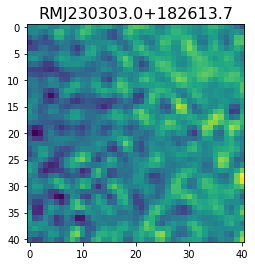

 52%|█████▏    | 811/1546 [00:47<00:30, 24.43it/s]

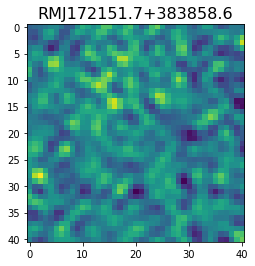

 53%|█████▎    | 815/1546 [00:47<00:32, 22.33it/s]

 53%|█████▎    | 819/1546 [00:47<00:34, 21.06it/s]

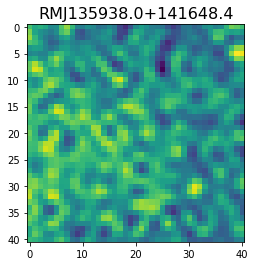

 53%|█████▎    | 823/1546 [00:47<00:34, 21.03it/s]

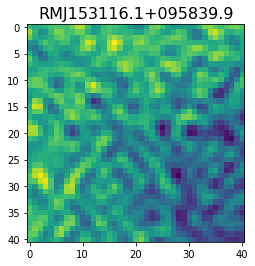

 53%|█████▎    | 826/1546 [00:47<00:42, 16.77it/s]

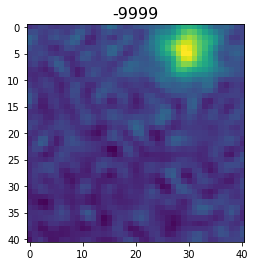

 54%|█████▎    | 828/1546 [00:48<00:45, 15.83it/s]

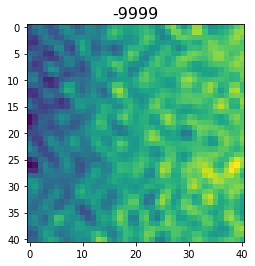

 54%|█████▎    | 830/1546 [00:48<00:52, 13.75it/s]

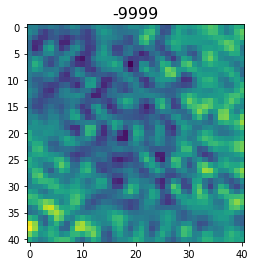

 54%|█████▍    | 832/1546 [00:48<00:52, 13.56it/s]

 54%|█████▍    | 834/1546 [00:48<00:53, 13.37it/s]

 54%|█████▍    | 836/1546 [00:48<00:54, 12.98it/s]

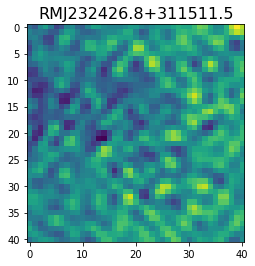

 55%|█████▍    | 844/1546 [00:49<00:37, 18.84it/s]

 55%|█████▍    | 847/1546 [00:49<00:37, 18.40it/s]

 55%|█████▍    | 850/1546 [00:49<00:38, 18.06it/s]

 55%|█████▌    | 853/1546 [00:49<00:38, 17.80it/s]

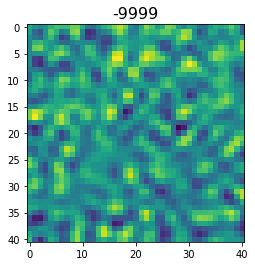

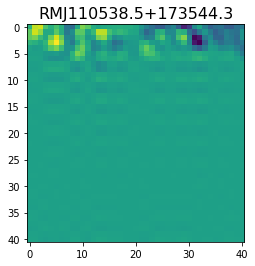

 55%|█████▌    | 855/1546 [00:50<00:50, 13.63it/s]

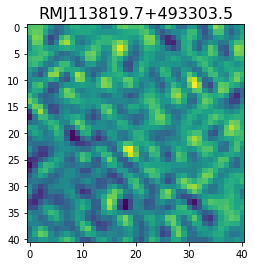

 55%|█████▌    | 857/1546 [00:50<00:51, 13.42it/s]

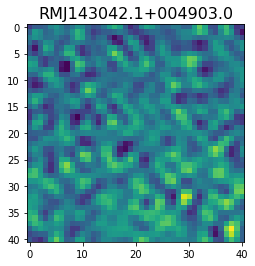

 56%|█████▌    | 860/1546 [00:50<00:47, 14.50it/s]

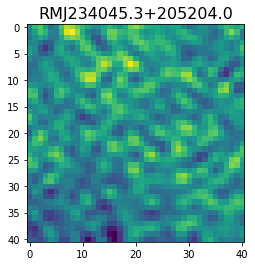

 56%|█████▌    | 862/1546 [00:50<01:04, 10.67it/s]

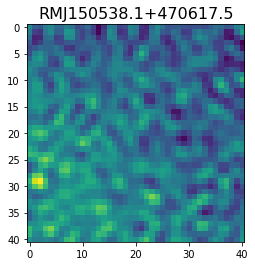

 56%|█████▌    | 864/1546 [00:50<01:01, 11.01it/s]

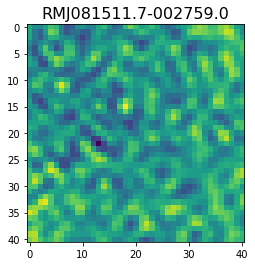

 56%|█████▌    | 866/1546 [00:51<01:11,  9.53it/s]

 56%|█████▌    | 868/1546 [00:51<01:05, 10.30it/s]

 57%|█████▋    | 876/1546 [00:51<00:35, 18.83it/s]

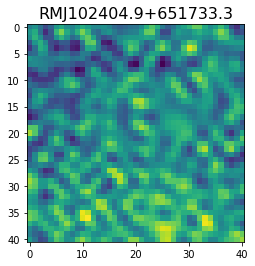

 57%|█████▋    | 879/1546 [00:51<00:39, 17.03it/s]

 57%|█████▋    | 881/1546 [00:51<00:41, 15.92it/s]

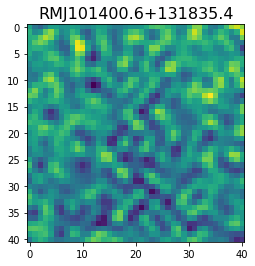

 57%|█████▋    | 883/1546 [00:52<00:44, 15.06it/s]

 57%|█████▋    | 887/1546 [00:52<00:39, 16.76it/s]

 58%|█████▊    | 889/1546 [00:52<00:42, 15.59it/s]

 58%|█████▊    | 891/1546 [00:52<00:44, 14.86it/s]

 58%|█████▊    | 893/1546 [00:52<00:51, 12.80it/s]

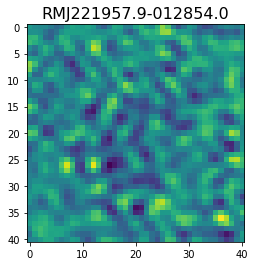

 58%|█████▊    | 895/1546 [00:52<00:50, 12.85it/s]

 58%|█████▊    | 897/1546 [00:53<01:01, 10.56it/s]

 58%|█████▊    | 901/1546 [00:53<00:47, 13.49it/s]

 58%|█████▊    | 904/1546 [00:53<00:44, 14.58it/s]

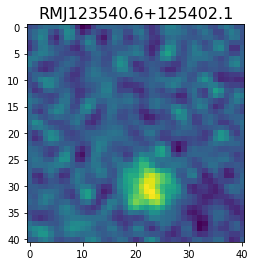

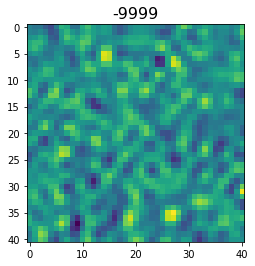

 59%|█████▉    | 912/1546 [00:54<00:33, 19.04it/s]

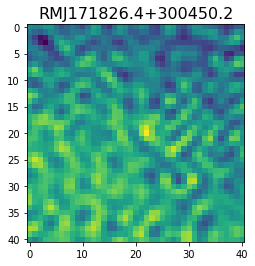

 59%|█████▉    | 915/1546 [00:54<00:33, 18.65it/s]

 59%|█████▉    | 918/1546 [00:54<00:34, 18.11it/s]

 60%|█████▉    | 921/1546 [00:54<00:34, 17.97it/s]

 60%|█████▉    | 925/1546 [00:54<00:33, 18.76it/s]

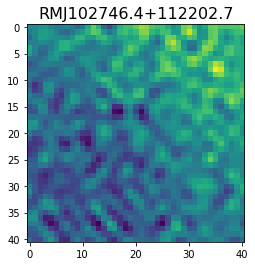

 60%|██████    | 928/1546 [00:54<00:34, 18.11it/s]

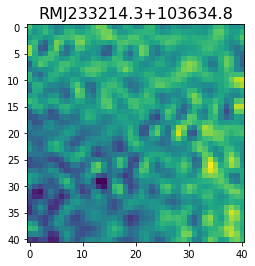

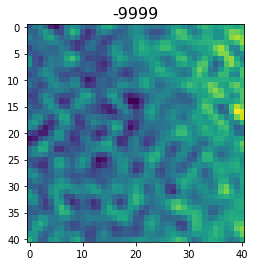

 60%|██████    | 930/1546 [00:55<00:48, 12.70it/s]

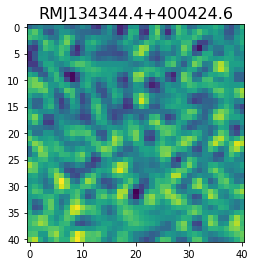

 60%|██████    | 935/1546 [00:55<00:38, 15.91it/s]

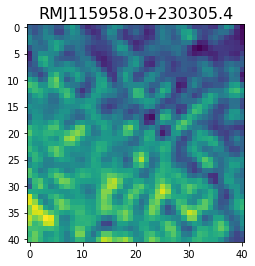

 61%|██████    | 937/1546 [00:55<00:40, 15.15it/s]

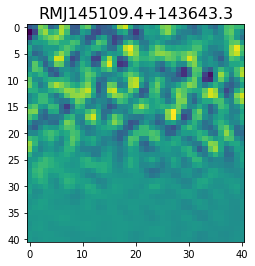

 61%|██████    | 942/1546 [00:55<00:34, 17.35it/s]

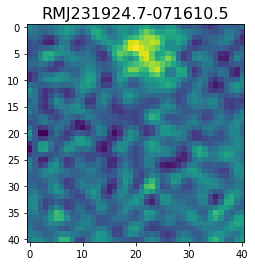

 61%|██████▏   | 947/1546 [00:56<00:32, 18.64it/s]

 61%|██████▏   | 949/1546 [00:56<00:35, 16.68it/s]

 62%|██████▏   | 951/1546 [00:56<00:39, 15.18it/s]

 62%|██████▏   | 953/1546 [00:56<00:41, 14.17it/s]

 62%|██████▏   | 955/1546 [00:56<00:44, 13.19it/s]

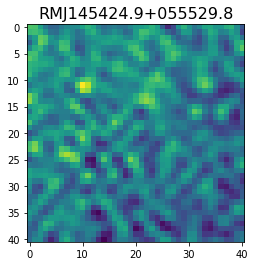

 62%|██████▏   | 962/1546 [00:57<00:30, 19.44it/s]

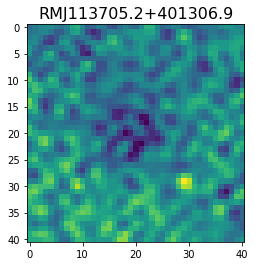

 62%|██████▏   | 965/1546 [00:57<00:39, 14.79it/s]

 63%|██████▎   | 969/1546 [00:57<00:38, 14.94it/s]

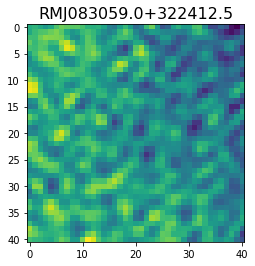

 63%|██████▎   | 977/1546 [00:57<00:27, 20.37it/s]

 63%|██████▎   | 980/1546 [00:58<00:30, 18.67it/s]

 64%|██████▎   | 983/1546 [00:58<00:31, 17.71it/s]

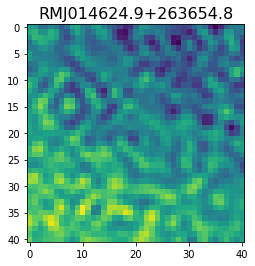

 64%|██████▍   | 986/1546 [00:58<00:40, 13.79it/s]

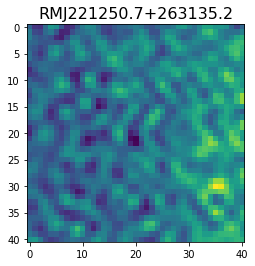

 64%|██████▍   | 989/1546 [00:58<00:39, 14.20it/s]

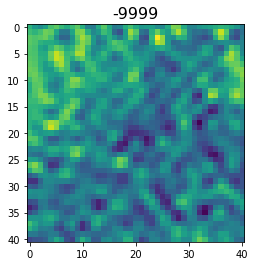

 64%|██████▍   | 993/1546 [00:59<00:34, 15.96it/s]

 65%|██████▍   | 1001/1546 [00:59<00:24, 22.23it/s]

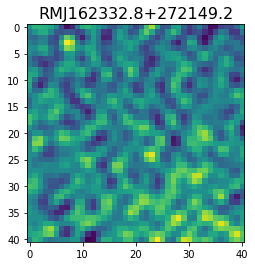

 65%|██████▍   | 1004/1546 [00:59<00:32, 16.53it/s]

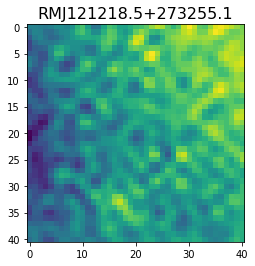

 65%|██████▌   | 1007/1546 [00:59<00:32, 16.43it/s]

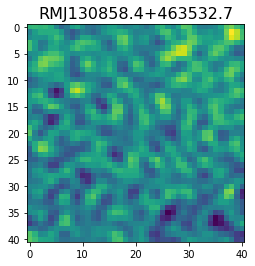

 65%|██████▌   | 1012/1546 [01:00<00:29, 18.39it/s]

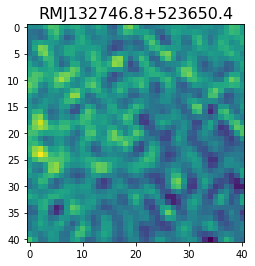

 66%|██████▌   | 1015/1546 [01:00<00:32, 16.40it/s]

 66%|██████▌   | 1017/1546 [01:00<00:34, 15.38it/s]

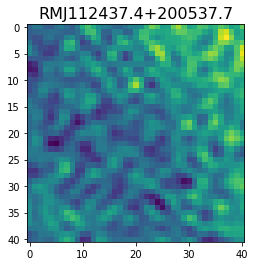

 66%|██████▌   | 1024/1546 [01:00<00:25, 20.25it/s]

 66%|██████▋   | 1027/1546 [01:01<00:28, 18.39it/s]

 67%|██████▋   | 1033/1546 [01:01<00:25, 19.93it/s]

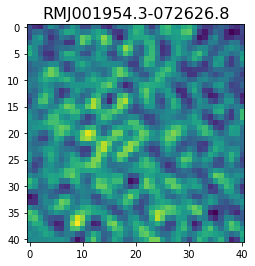

 67%|██████▋   | 1036/1546 [01:01<00:28, 17.88it/s]

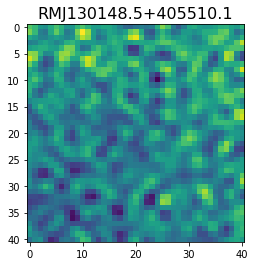

 67%|██████▋   | 1040/1546 [01:01<00:27, 18.12it/s]

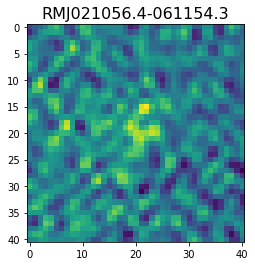

 68%|██████▊   | 1050/1546 [01:02<00:20, 24.13it/s]

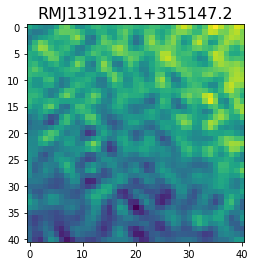

 68%|██████▊   | 1053/1546 [01:02<00:23, 20.77it/s]

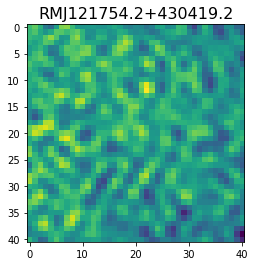

 69%|██████▊   | 1061/1546 [01:02<00:19, 24.51it/s]

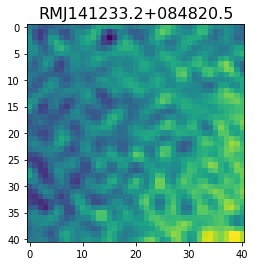

 69%|██████▉   | 1064/1546 [01:02<00:21, 22.01it/s]

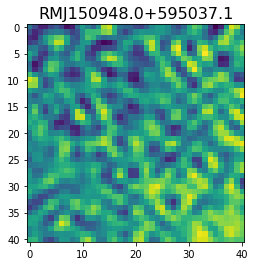

 69%|██████▉   | 1067/1546 [01:02<00:23, 20.23it/s]

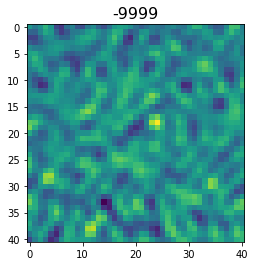

 69%|██████▉   | 1071/1546 [01:03<00:24, 19.54it/s]

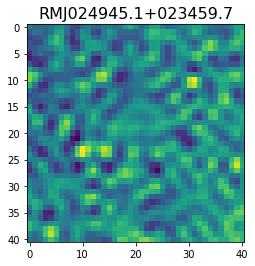

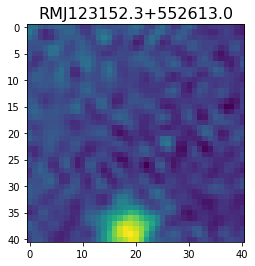

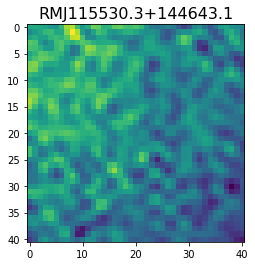

 70%|██████▉   | 1079/1546 [01:03<00:28, 16.51it/s]

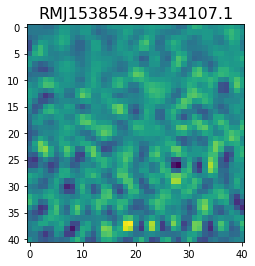

 70%|███████   | 1087/1546 [01:04<00:21, 20.94it/s]

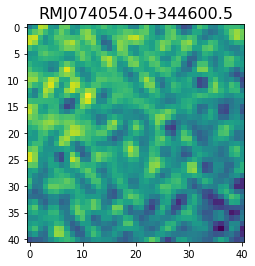

 71%|███████   | 1090/1546 [01:04<00:23, 19.30it/s]

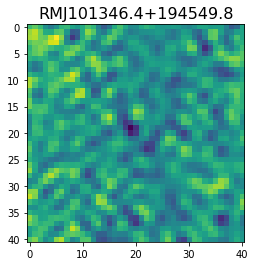

 71%|███████   | 1095/1546 [01:04<00:22, 19.79it/s]

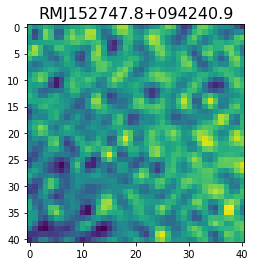

 71%|███████   | 1098/1546 [01:04<00:24, 18.56it/s]

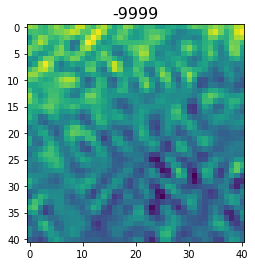

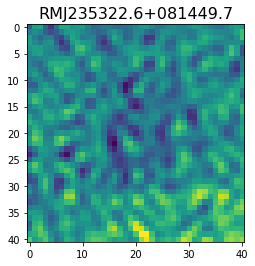

 71%|███████   | 1101/1546 [01:05<00:29, 14.98it/s]

 71%|███████▏  | 1103/1546 [01:05<00:30, 14.37it/s]

 71%|███████▏  | 1105/1546 [01:05<00:37, 11.68it/s]

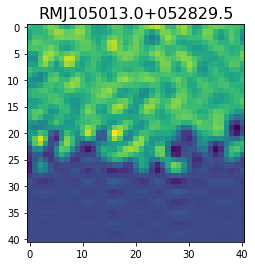

 72%|███████▏  | 1110/1546 [01:05<00:29, 14.88it/s]

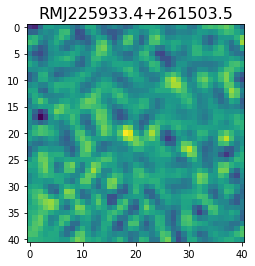

 72%|███████▏  | 1112/1546 [01:06<00:38, 11.35it/s]

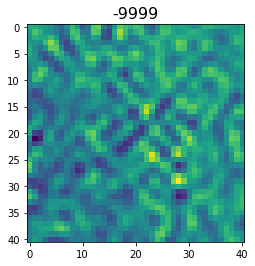

 72%|███████▏  | 1114/1546 [01:06<00:37, 11.62it/s]

 72%|███████▏  | 1116/1546 [01:06<00:36, 11.83it/s]

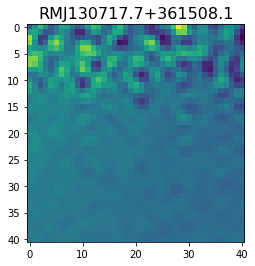

 72%|███████▏  | 1118/1546 [01:06<00:35, 11.98it/s]

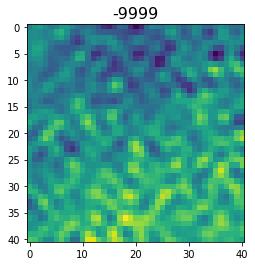

 72%|███████▏  | 1120/1546 [01:06<00:35, 12.12it/s]

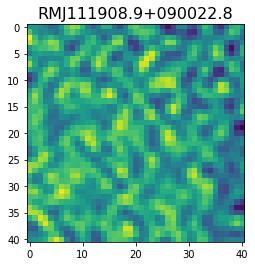

 73%|███████▎  | 1122/1546 [01:06<00:34, 12.15it/s]

 73%|███████▎  | 1124/1546 [01:07<00:34, 12.21it/s]

 73%|███████▎  | 1126/1546 [01:07<00:34, 12.31it/s]

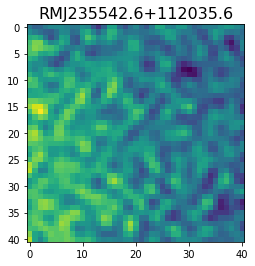

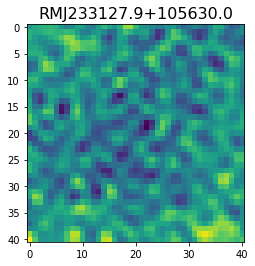

 73%|███████▎  | 1128/1546 [01:07<00:41, 10.16it/s]

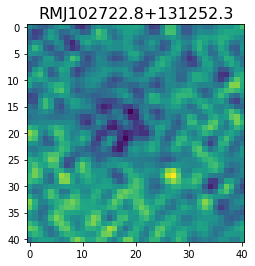

 73%|███████▎  | 1130/1546 [01:07<00:38, 10.79it/s]

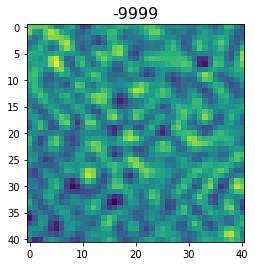

 73%|███████▎  | 1132/1546 [01:07<00:47,  8.76it/s]

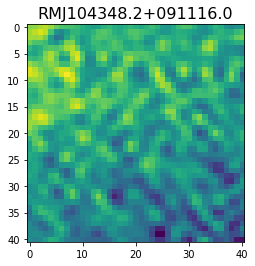

 74%|███████▍  | 1142/1546 [01:08<00:20, 19.48it/s]

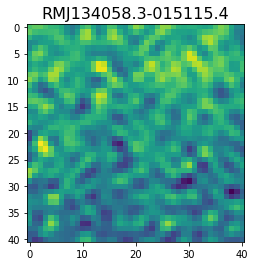

 74%|███████▍  | 1145/1546 [01:08<00:21, 18.83it/s]

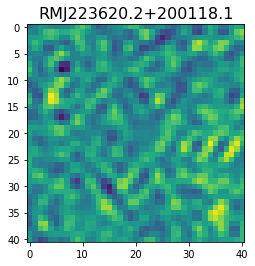

 74%|███████▍  | 1148/1546 [01:08<00:22, 17.89it/s]

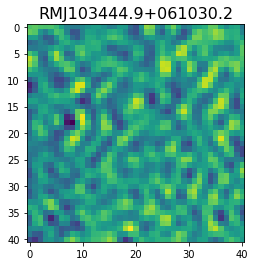

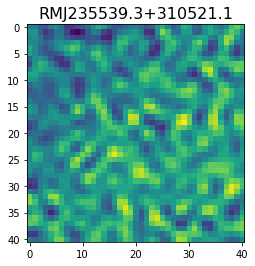

 74%|███████▍  | 1151/1546 [01:08<00:26, 14.71it/s]

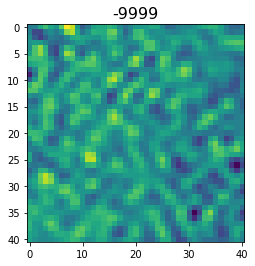

 75%|███████▍  | 1153/1546 [01:09<00:27, 14.30it/s]

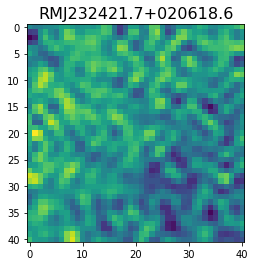

 75%|███████▍  | 1155/1546 [01:09<00:28, 13.86it/s]

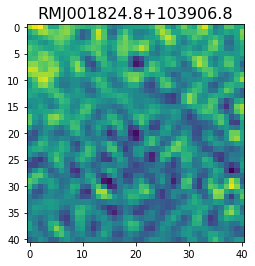

 75%|███████▌  | 1162/1546 [01:09<00:19, 19.89it/s]

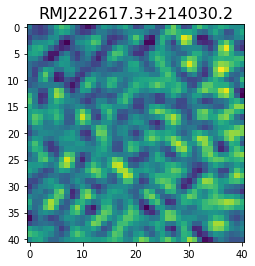

 75%|███████▌  | 1165/1546 [01:10<00:31, 12.25it/s]

 76%|███████▌  | 1172/1546 [01:10<00:21, 17.64it/s]

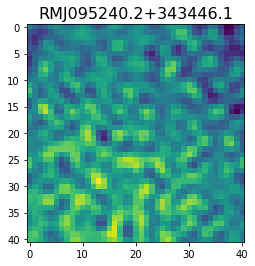

 76%|███████▋  | 1180/1546 [01:10<00:17, 21.34it/s]

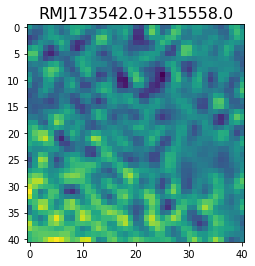

 77%|███████▋  | 1185/1546 [01:10<00:17, 21.13it/s]

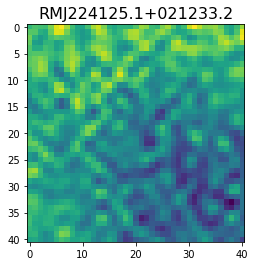

 77%|███████▋  | 1188/1546 [01:11<00:19, 18.84it/s]

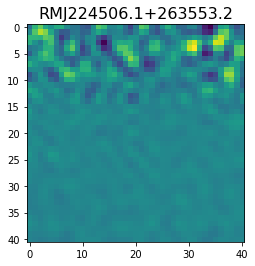

 77%|███████▋  | 1195/1546 [01:11<00:16, 20.74it/s]

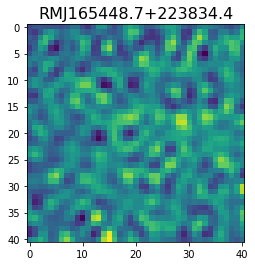

 78%|███████▊  | 1199/1546 [01:11<00:17, 19.44it/s]

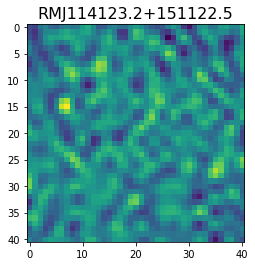

 78%|███████▊  | 1202/1546 [01:11<00:19, 17.88it/s]

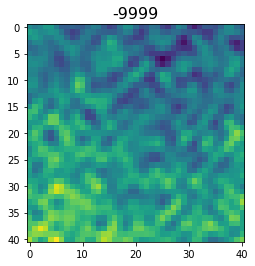

 78%|███████▊  | 1204/1546 [01:12<00:21, 16.22it/s]

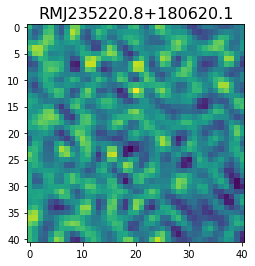

 78%|███████▊  | 1207/1546 [01:12<00:21, 15.94it/s]

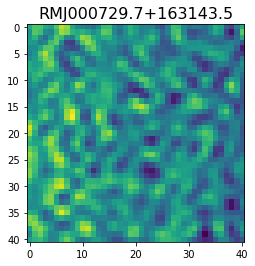

 78%|███████▊  | 1209/1546 [01:12<00:22, 14.69it/s]

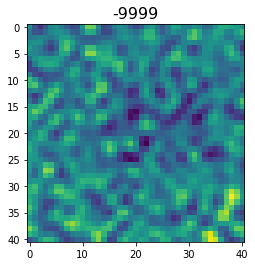

 79%|███████▊  | 1216/1546 [01:12<00:16, 20.55it/s]

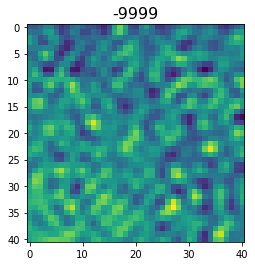

 79%|███████▉  | 1219/1546 [01:12<00:17, 18.85it/s]

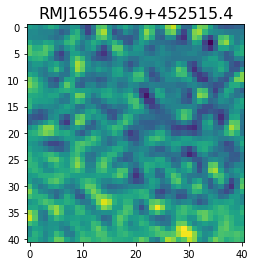

 79%|███████▉  | 1224/1546 [01:13<00:16, 19.82it/s]

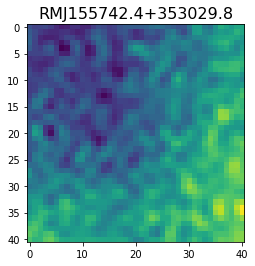

 79%|███████▉  | 1227/1546 [01:13<00:17, 18.44it/s]

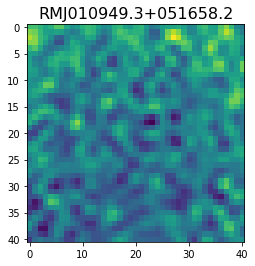

 79%|███████▉  | 1229/1546 [01:13<00:25, 12.51it/s]

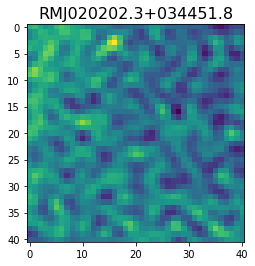

 80%|███████▉  | 1231/1546 [01:13<00:25, 12.22it/s]

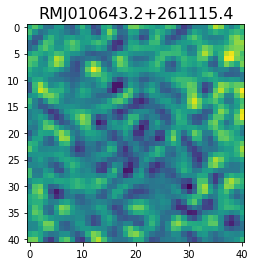

 80%|███████▉  | 1234/1546 [01:14<00:23, 13.10it/s]

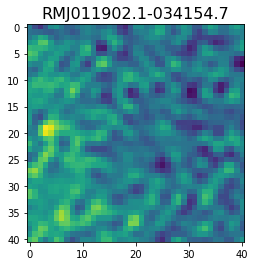

 80%|████████  | 1237/1546 [01:14<00:22, 13.75it/s]

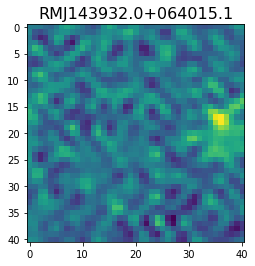

 80%|████████  | 1239/1546 [01:14<00:23, 13.17it/s]

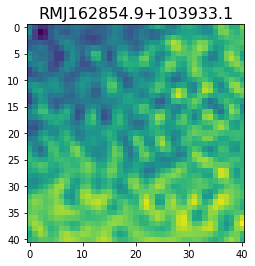

 80%|████████  | 1244/1546 [01:14<00:19, 15.66it/s]

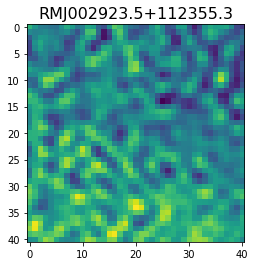

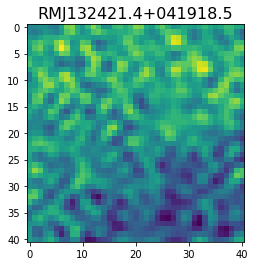

 81%|████████  | 1246/1546 [01:14<00:25, 11.95it/s]

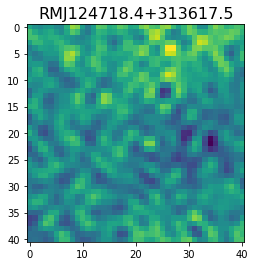

 81%|████████  | 1249/1546 [01:15<00:23, 12.89it/s]

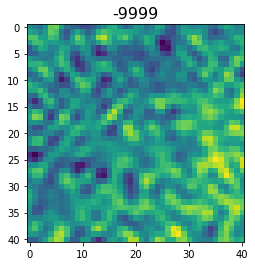

 81%|████████  | 1251/1546 [01:15<00:23, 12.60it/s]

 81%|████████  | 1254/1546 [01:15<00:22, 13.13it/s]

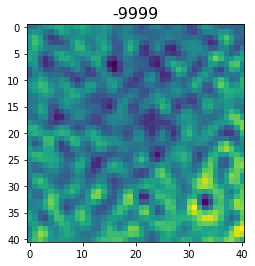

 82%|████████▏ | 1268/1546 [01:15<00:10, 26.26it/s]

 82%|████████▏ | 1272/1546 [01:16<00:15, 17.36it/s]

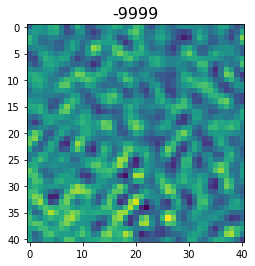

 82%|████████▏ | 1275/1546 [01:16<00:16, 16.77it/s]

 83%|████████▎ | 1278/1546 [01:16<00:16, 16.24it/s]

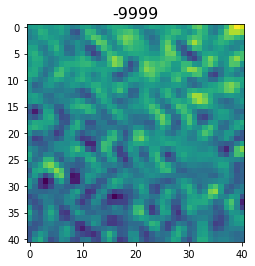

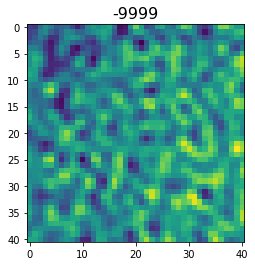

 83%|████████▎ | 1281/1546 [01:17<00:19, 13.43it/s]

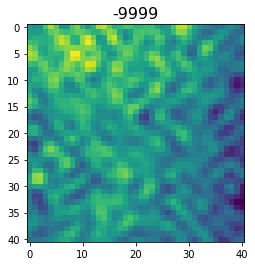

 83%|████████▎ | 1283/1546 [01:17<00:20, 13.07it/s]

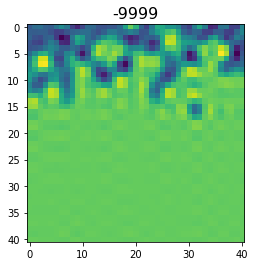

 83%|████████▎ | 1285/1546 [01:17<00:20, 12.69it/s]

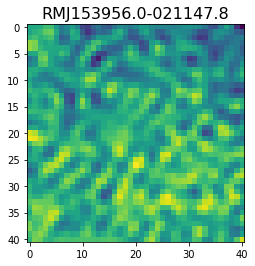

 83%|████████▎ | 1289/1546 [01:17<00:17, 14.53it/s]

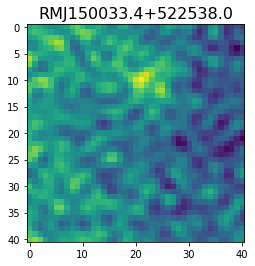

 84%|████████▍ | 1295/1546 [01:17<00:13, 18.23it/s]

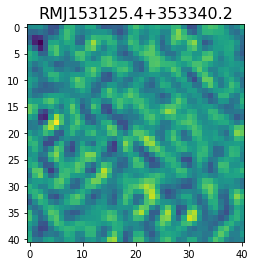

 84%|████████▍ | 1297/1546 [01:18<00:14, 16.75it/s]

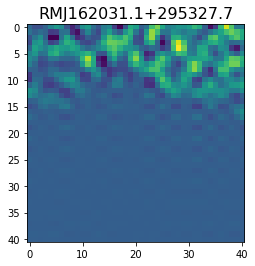

 84%|████████▍ | 1299/1546 [01:18<00:15, 15.64it/s]

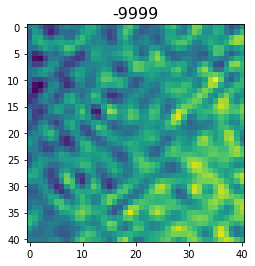

 84%|████████▍ | 1302/1546 [01:18<00:15, 16.01it/s]

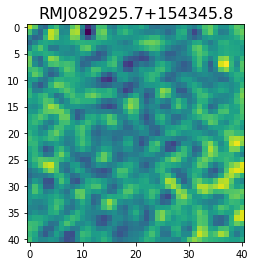

 84%|████████▍ | 1304/1546 [01:18<00:17, 13.57it/s]

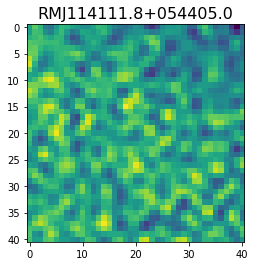

 85%|████████▍ | 1312/1546 [01:18<00:10, 21.49it/s]

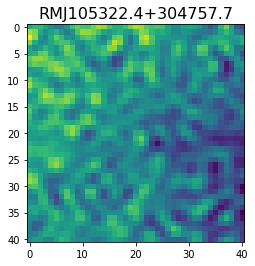

 85%|████████▌ | 1315/1546 [01:19<00:11, 19.92it/s]

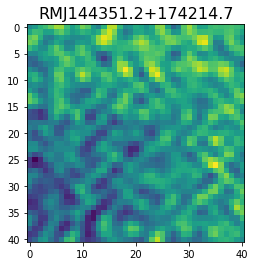

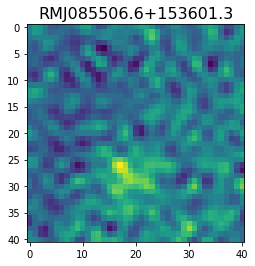

 85%|████████▌ | 1318/1546 [01:19<00:14, 15.63it/s]

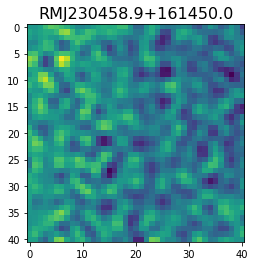

 85%|████████▌ | 1320/1546 [01:19<00:15, 14.62it/s]

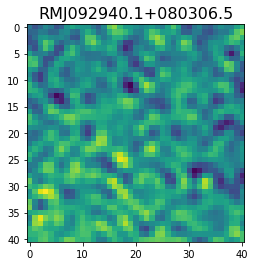

 86%|████████▌ | 1322/1546 [01:19<00:16, 13.98it/s]

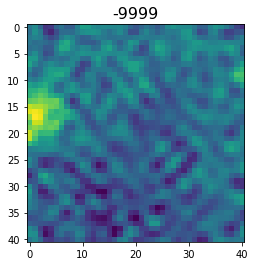

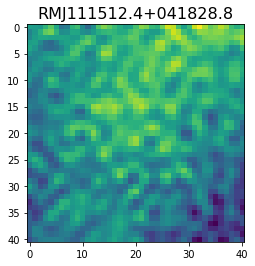

 86%|████████▌ | 1324/1546 [01:20<00:19, 11.23it/s]

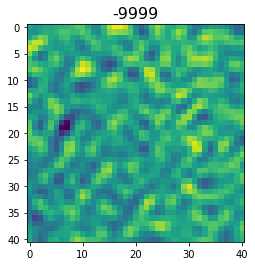

 86%|████████▌ | 1328/1546 [01:20<00:15, 13.72it/s]

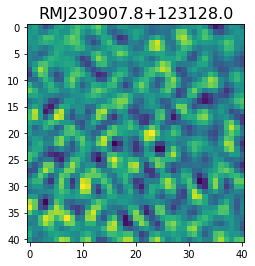

 86%|████████▌ | 1330/1546 [01:20<00:16, 13.26it/s]

 87%|████████▋ | 1339/1546 [01:20<00:09, 21.46it/s]

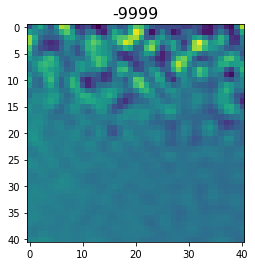

 87%|████████▋ | 1342/1546 [01:20<00:10, 19.69it/s]

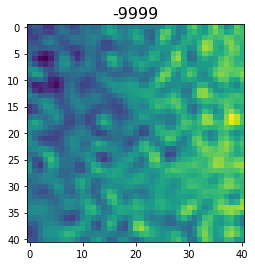

 87%|████████▋ | 1345/1546 [01:21<00:12, 16.41it/s]

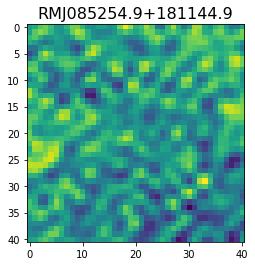

 87%|████████▋ | 1347/1546 [01:21<00:12, 15.43it/s]

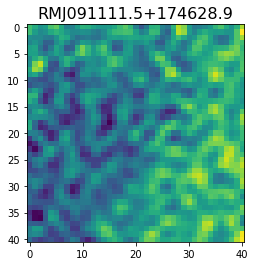

 87%|████████▋ | 1350/1546 [01:21<00:13, 14.63it/s]

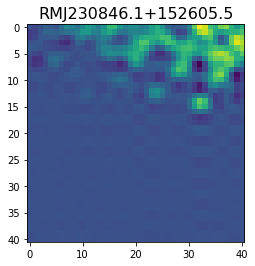

 88%|████████▊ | 1353/1546 [01:21<00:12, 15.14it/s]

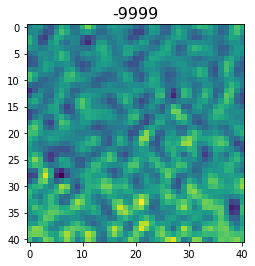

 88%|████████▊ | 1357/1546 [01:21<00:11, 16.59it/s]

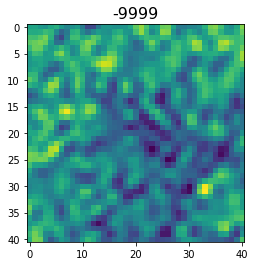

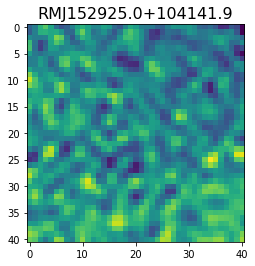

 88%|████████▊ | 1359/1546 [01:22<00:14, 13.02it/s]

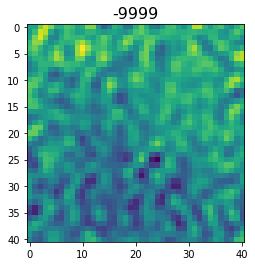

 88%|████████▊ | 1362/1546 [01:22<00:13, 13.98it/s]

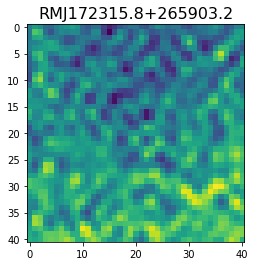

 88%|████████▊ | 1364/1546 [01:22<00:13, 13.71it/s]

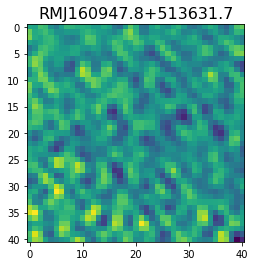

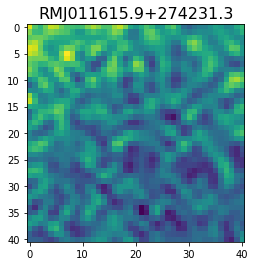

 88%|████████▊ | 1366/1546 [01:22<00:15, 11.25it/s]

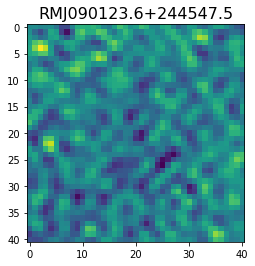

 88%|████████▊ | 1368/1546 [01:22<00:15, 11.56it/s]

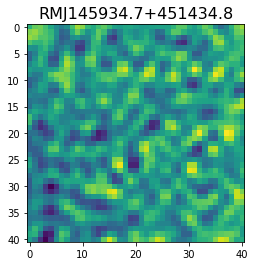

 89%|████████▊ | 1372/1546 [01:23<00:12, 13.93it/s]

 89%|████████▉ | 1382/1546 [01:23<00:07, 20.64it/s]

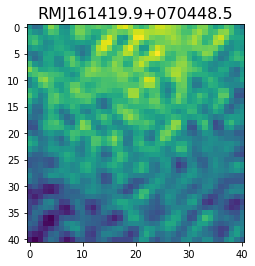

 90%|████████▉ | 1385/1546 [01:23<00:08, 19.04it/s]

 90%|████████▉ | 1389/1546 [01:23<00:08, 19.47it/s]

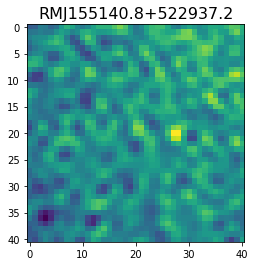

 90%|█████████ | 1392/1546 [01:24<00:08, 18.41it/s]

 90%|█████████ | 1395/1546 [01:24<00:08, 17.88it/s]

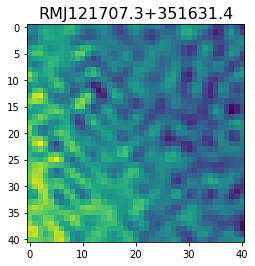

 91%|█████████ | 1402/1546 [01:24<00:06, 22.67it/s]

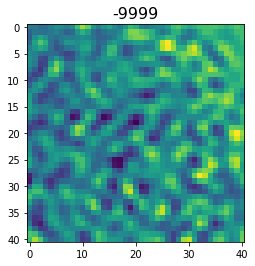

 91%|█████████ | 1406/1546 [01:24<00:06, 21.63it/s]

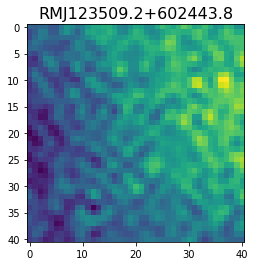

 91%|█████████ | 1409/1546 [01:25<00:08, 16.43it/s]

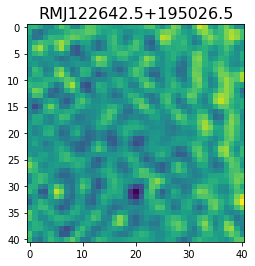

 91%|█████████▏| 1412/1546 [01:25<00:08, 16.45it/s]

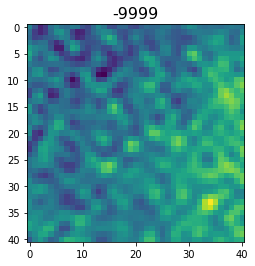

 91%|█████████▏| 1414/1546 [01:25<00:08, 15.27it/s]

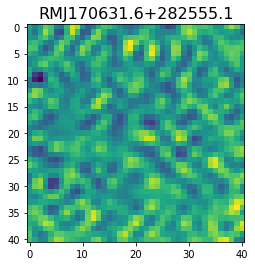

 92%|█████████▏| 1418/1546 [01:25<00:07, 17.03it/s]

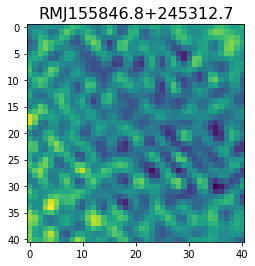

 92%|█████████▏| 1421/1546 [01:25<00:07, 17.01it/s]

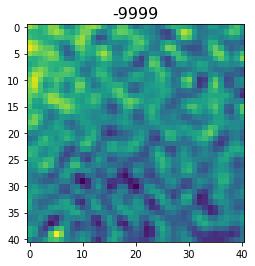

 92%|█████████▏| 1426/1546 [01:26<00:06, 17.18it/s]

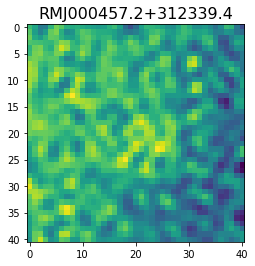

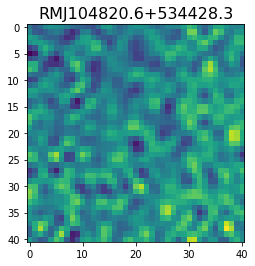

 92%|█████████▏| 1428/1546 [01:26<00:08, 13.53it/s]

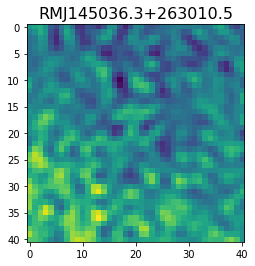

 92%|█████████▏| 1430/1546 [01:26<00:08, 13.28it/s]

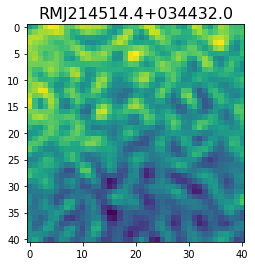

 93%|█████████▎| 1432/1546 [01:26<00:08, 13.17it/s]

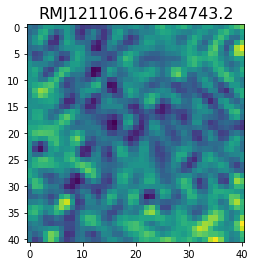

 93%|█████████▎| 1436/1546 [01:26<00:07, 15.40it/s]

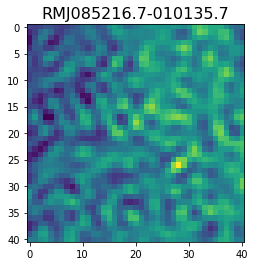

 94%|█████████▎| 1447/1546 [01:27<00:04, 23.64it/s]

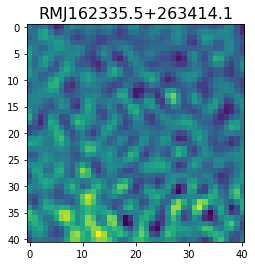

 94%|█████████▍| 1450/1546 [01:27<00:04, 21.48it/s]

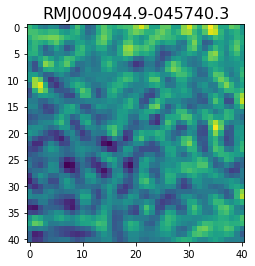

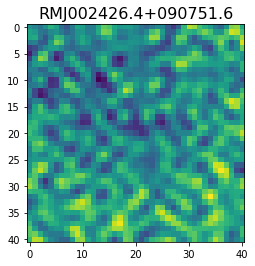

 94%|█████████▍| 1453/1546 [01:27<00:05, 16.74it/s]

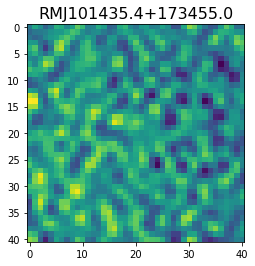

 94%|█████████▍| 1456/1546 [01:27<00:05, 16.69it/s]

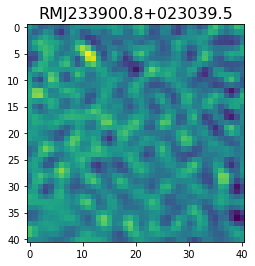

 95%|█████████▍| 1464/1546 [01:28<00:03, 23.10it/s]

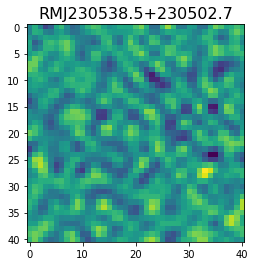

 95%|█████████▍| 1467/1546 [01:28<00:03, 21.07it/s]

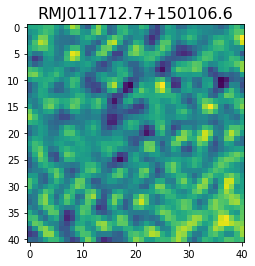

 95%|█████████▌| 1471/1546 [01:28<00:03, 19.04it/s]

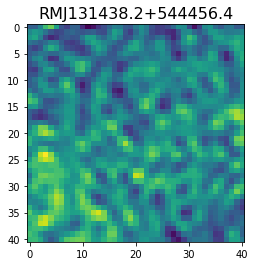

 95%|█████████▌| 1475/1546 [01:28<00:03, 19.06it/s]

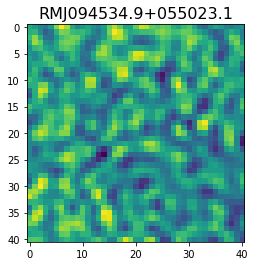

 96%|█████████▌| 1478/1546 [01:29<00:03, 18.32it/s]

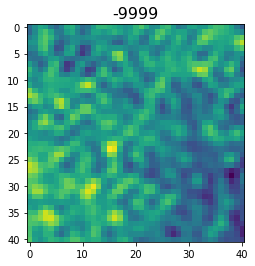

 96%|█████████▌| 1484/1546 [01:29<00:03, 20.58it/s]

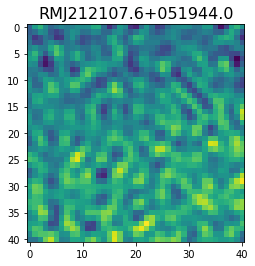

 96%|█████████▌| 1487/1546 [01:29<00:02, 19.71it/s]

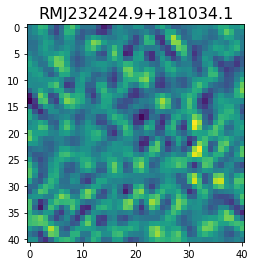

 97%|█████████▋| 1495/1546 [01:29<00:02, 24.93it/s]

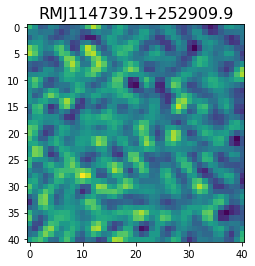

 97%|█████████▋| 1498/1546 [01:29<00:02, 22.01it/s]

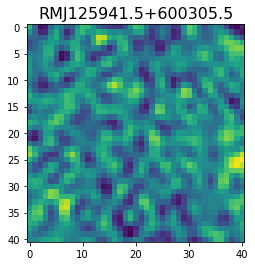

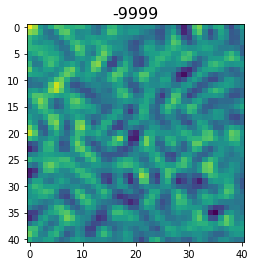

 97%|█████████▋| 1501/1546 [01:30<00:02, 16.68it/s]

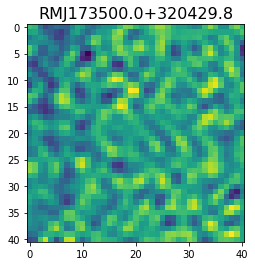

 97%|█████████▋| 1504/1546 [01:30<00:02, 16.59it/s]

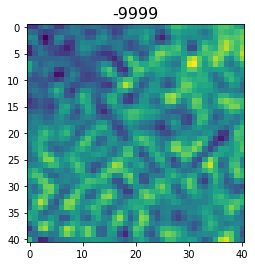

 98%|█████████▊| 1510/1546 [01:30<00:01, 19.38it/s]

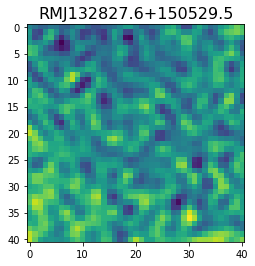

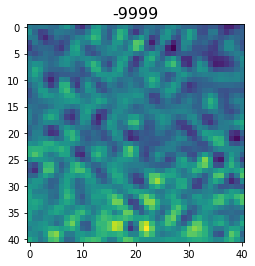

 98%|█████████▊| 1513/1546 [01:30<00:02, 15.59it/s]

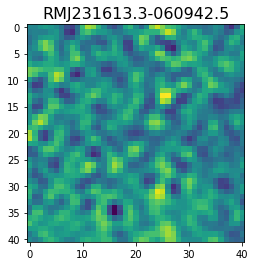

 98%|█████████▊| 1515/1546 [01:31<00:02, 13.40it/s]

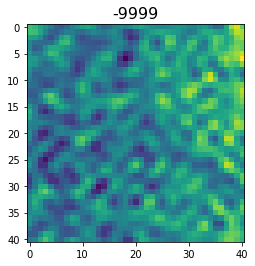

 98%|█████████▊| 1518/1546 [01:31<00:01, 14.13it/s]

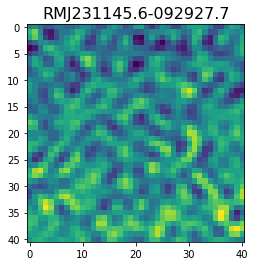

 98%|█████████▊| 1521/1546 [01:31<00:01, 14.75it/s]

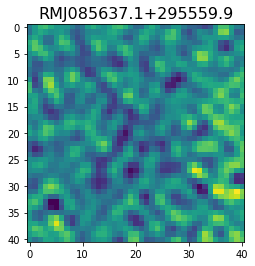

 99%|█████████▊| 1526/1546 [01:31<00:01, 17.23it/s]

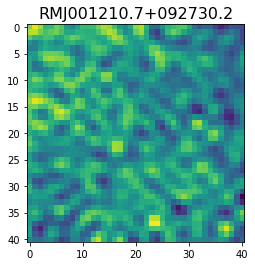

 99%|█████████▉| 1528/1546 [01:31<00:01, 15.77it/s]

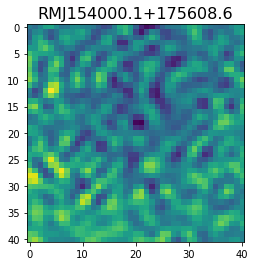

 99%|█████████▉| 1531/1546 [01:32<00:00, 15.98it/s]

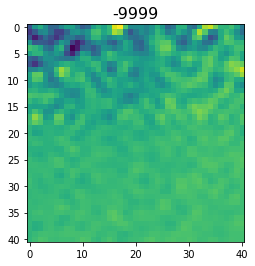

 99%|█████████▉| 1536/1546 [01:32<00:00, 17.96it/s]

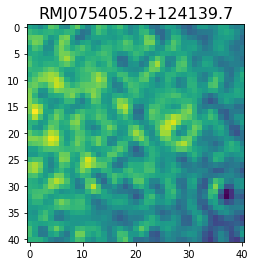

 99%|█████████▉| 1538/1546 [01:32<00:00, 16.42it/s]

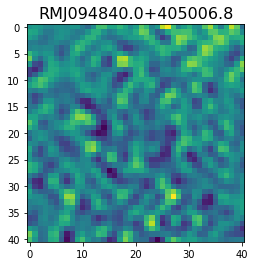

100%|█████████▉| 1542/1546 [01:32<00:00, 17.50it/s]

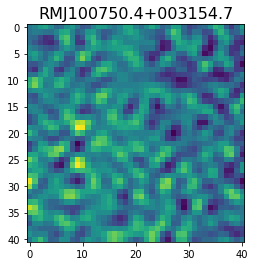

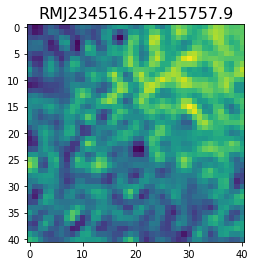

100%|██████████| 1546/1546 [01:33<00:00, 16.61it/s]


In [19]:
stamps90 = []

# ras  = ard_not_adv['amf_ra']
# decs = ard_not_adv['amf_dec']
ras  = ard_not_adv[ard_not_adv.amf_rh>50]['amf_ra']
decs = ard_not_adv[ard_not_adv.amf_rh>50]['amf_dec']
# ras  = amf[amf.amf_rh>50]['amf_ra']
# decs = amf[amf.amf_rh>50]['amf_dec']

N = len(ras)
# N=200
stack_CMB_kSZ           = 0
stack_CMB_kSZ_deproject = 0
c = 0

for i in tqdm(range(N)):
    stamp = reproject.thumbnails(actmap,coords = np.deg2rad([decs[i], ras[i]]),r=5*utils.arcmin)
#     stamp_1arc = reproject.thumbnails(actmap,coords = np.deg2rad([decs[i], ras[i]]),r=5*utils.arcmin)
    
    if stamp is None:
        continue
    elif stamp[0][0][0]==0.0:
        continue
        
    stamps90.append(sum(sum(stamp[0])))
    
    stack_CMB_kSZ += stamp 
    c += 1
    plt.imshow(stamp[0])
    plt.title(amf.iloc[i]['red_id'], fontsize = 16)
#     plt.savefig('ex{}.png'.format(i))
    plt.show()
    
# Normalize the stamps
stack_CMB_kSZ /= c
stack_CMB_kSZ_deproject /= c

In [ ]:
np.average(stamps90)

In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='stix'
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150
plt.rcParams['axes.facecolor'] = 'white'

freq = [90,150,220]
full = [-710,-610,615]
highrh = [-1305,-1760,-595]
plt.scatter(freq,highrh,marker='x',c='r')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Avg. signal")
plt.title("High richness clusters",size=16)
plt.grid()
plt.savefig('highrh.png')

In [21]:
# Now we can plot both of these and compare
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

f, ax = plt.subplots(1,2, figsize=(10, 5))

f1 = ax[0].imshow(stack_CMB_kSZ[0])
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

scalebar = AnchoredSizeBar(ax[0].transData,
                           19.8, '', 'center left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=0.1)

ax[0].add_artist(scalebar)
ax[0].text(1,22,"5 arcmin",color='white')
ax[0].set_title("Stacked sources: 90 GHz", fontsize = 16)
plt.colorbar(mappable = f1, ax = ax[0],orientation='horizontal')

plt.show()
plt.savefig("90.png")

<Figure size 432x288 with 0 Axes>

---